In [3]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
from gower import gower_distances
from scipy.spatial.distance import squareform 
from scipy.cluster.hierarchy import linkage,cophenet,dendrogram,fcluster
np.set_printoptions(precision=5, suppress=True)
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
# import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics
# from kmodes.kmodes import KModes
# from kmodes.kprototypes import KPrototypes
import kmedoids1

In [4]:
#read the species x traits matrix
df= pd.read_table("../data/T.dta",delimiter='\t')
df.rename( columns={'Unnamed: 0':'Species_code'}, inplace=True )


true_df = df
#Creating two datasets one with categorical values and the other one without
df_with_categorical_values = df.drop(['Species_code'],axis=1)
df_without_categorical_values = df.drop(['Species_code','AM','ECM','A.G','Disp'],axis=1)
#df_without_categorical_values.head()
df_with_categorical_values.head()


cols_to_keep = ['AM','ECM','A.G','Disp']
df_cat = df[cols_to_keep]
df.head()

df.to_csv('species_traits.csv')

In [3]:
#Read benchmark data
df2 = pd.read_table("../data/FG.out",delimiter='\t')
df2.rename( columns={'Unnamed: 0':'Species_index'}, inplace=True )
#La colonne 10 représente le ground truth
#print(df2.groupby("10").count()['Species_index'])
true_df.head()
true_df["class"] = pd.Series(df2['10'])
target = true_df["class"]
print(true_df.groupby("class").count()['Species_code'])

class
1     20
2     42
3     37
4      9
5     38
6     37
7     39
8     19
9      8
10    22
Name: Species_code, dtype: int64


In [4]:
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
df_with_catval_encoded = ohe.fit_transform(df_with_categorical_values)

In [5]:
def mergelist(dataframe, listofseries):
    for serie in listofseries:
        dataframe = dataframe.join(serie)
    return dataframe

#Since the clustering is sensitive to range of data. It is advisable to scale the data before proceeding.
scaler = MinMaxScaler(feature_range=(0,1))

scaled_df = scaler.fit_transform(df_without_categorical_values)
df_without_categorical_values = pd.DataFrame(scaled_df, columns=df_without_categorical_values.columns.values.tolist())


scaled_catval_df = scaler.fit_transform(df_with_catval_encoded)
df_with_catval_encoded = pd.DataFrame(scaled_catval_df, columns=df_with_catval_encoded.columns.values.tolist())
#df_with_catval_encoded.head()

num_scaled_with_cat = df_without_categorical_values
num_scaled_with_cat = num_scaled_with_cat.join(df_cat)
#num_scaled_with_cat.head()

categories =["Small","Medium","Large"]

df_seedm = pd.cut(num_scaled_with_cat['SeedM'],3,labels =categories)
df_wd = pd.cut(num_scaled_with_cat['Wd'],3,labels =categories)
df_lma = pd.qcut(num_scaled_with_cat['LMA'],3,labels =categories)
df_nmass = pd.cut(num_scaled_with_cat['Nmass'],3,labels =categories)
df_shade = pd.cut(num_scaled_with_cat['Shade-T'],3,labels =categories)
df_drought = pd.cut(num_scaled_with_cat['Drought-T'],3,labels =categories)
df_waterlog = pd.cut(num_scaled_with_cat['Waterlog-T '],3,labels =categories)
serie_list = [df_seedm, df_wd, df_lma, df_nmass, df_shade,df_drought,df_waterlog]

df_all_cat = df_cat
df_all_cat= mergelist(df_all_cat, serie_list)
df_all_cat.head()


AM ECM A.G Disp   SeedM     Wd    LMA  Nmass Shade-T Drought-T Waterlog-T 
0  N   Y   G    W  Medium  Small  Large  Small   Large    Medium       Small
1  N   Y   G    W   Small  Small  Large  Small   Large     Small       Small
2  N   Y   G    W  Medium  Small  Large  Small   Large    Medium       Small
3  N   Y   G    W   Small  Small  Large  Small   Large     Small       Small
4  N   Y   G    W   Small  Small  Large  Small   Large     Small       Small

In [6]:
def show_output(label,target,method, k):
    """
    Performs appropiate permutation
    Calculates overlap and confusion matrix
    
    Parameters:
    ----------
        label: cluster group predicted by cluster algorithm
        target: benchmark cluster group
        method: method used for clustering
        
    """
    # label = y_pred
    # target = y_true


    labels = np.zeros_like(label)
    for i in range(10):
        mask = (label == i)
        labels[mask] = mode(target[mask])[0]
    
     
    print("Method: %s"%(method))
    print("Percentage overlap with default clustering:%0.3f"%(accuracy_score(target,labels)))
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(target, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(target, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(target, labels))
    print("\n\nConfusion matrix:")
    mat = confusion_matrix(target,labels)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=[1,2,3,4,5,6,7,8,9,10],
                yticklabels=[1,2,3,4,5,6,7,8,9,10])
    
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

    


In [7]:
def kmeans_clust(nb_clust, inputDataset, algo='full'):
    kmeans = KMeans(n_clusters=nb_clust, random_state=0, algorithm=algo)
    clusters = kmeans.fit_predict(inputDataset)
    return clusters, kmeans

In [8]:
def plot_clust(clusters, model):
    plt.scatter(df_without_categorical_values.iloc[:, 1].values, df_without_categorical_values.iloc[:, 0].values, c=clusters, s=50, cmap='viridis')
    if model!=0:
        centers = model.cluster_centers_
        plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5);

In [9]:
kclust = 10

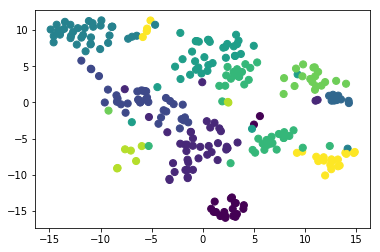

In [10]:
# Project the data in a space of two dimensions with TSNE
tsne = TSNE(n_components=2, init='random', random_state=0)
dataset_proj_tsne = tsne.fit_transform(df_without_categorical_values)
plt.scatter(dataset_proj_tsne[:,0], dataset_proj_tsne[:,1], c=target, s=50, cmap='viridis')

plt.show()

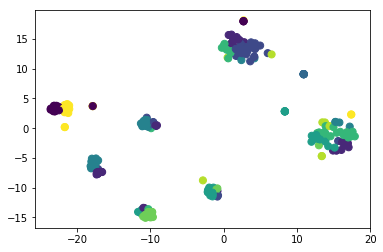

In [11]:
# Project the data in a space of two dimensions with TSNE
tsne = TSNE(n_components=2, init='random', random_state=0)
dataset_proj_tsne = tsne.fit_transform(df_with_catval_encoded)
plt.scatter(dataset_proj_tsne[:,0], dataset_proj_tsne[:,1], c=target, s=50, cmap='viridis')

plt.show()

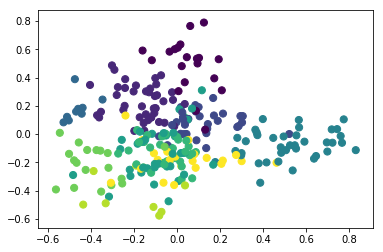

In [12]:
#Project the data in a space of two dimensions with PCA
pca = PCA(n_components=2)
dataset_proj_pca = pca.fit_transform(df_without_categorical_values)

plt.scatter(dataset_proj_pca[:,0], dataset_proj_pca[:,1], c=target, s=50, cmap='viridis')

plt.show()

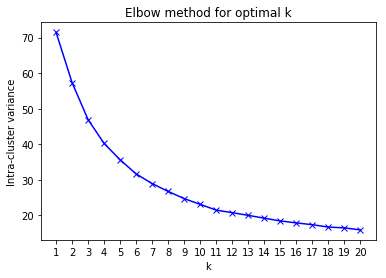

In [42]:
#Before begining, we try to found the optimal number of clusters for only the numerical values
Sum_of_squared_distances = []
K = range(1,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_without_categorical_values)
    Sum_of_squared_distances.append(km.inertia_)

plt.xticks(K)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Intra-cluster variance')
plt.title('Elbow method for optimal k')
plt.show()

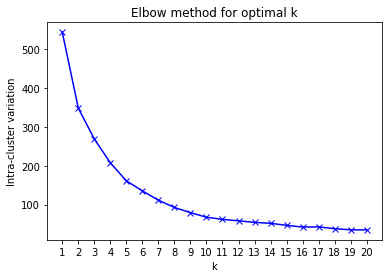

In [43]:
#Before begining, we try to found the optimal number of clusters for numerical and categorical values one hot encoded and scaled
Sum_of_squared_distances = []
K = range(1,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_with_catval_encoded)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.xticks(K)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Intra-cluster variation')
plt.title('Elbow method for optimal k')
plt.show()

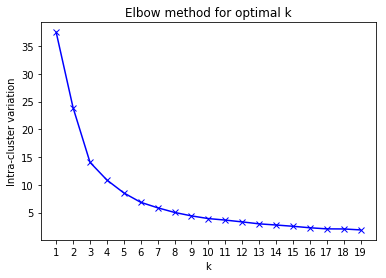

In [44]:
#Before begining, we try to found the optimal number of clusters for pca projection
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_proj_pca)
    Sum_of_squared_distances.append(km.inertia_)

plt.xticks(K)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Intra-cluster variation')
plt.title('Elbow method for optimal k')
plt.show()

In [16]:
from sklearn.metrics import silhouette_score

for n_clusters in range(2,20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_without_categorical_values)
    centers = clusterer.cluster_centers_

    score = silhouette_score(df_without_categorical_values, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.24267152178910137)
For n_clusters = 3, silhouette score is 0.20852457669959884)
For n_clusters = 4, silhouette score is 0.22053128772548267)
For n_clusters = 5, silhouette score is 0.22508644691504068)
For n_clusters = 6, silhouette score is 0.24409158711959325)
For n_clusters = 7, silhouette score is 0.252669995226217)
For n_clusters = 8, silhouette score is 0.24601460254062596)
For n_clusters = 9, silhouette score is 0.26690567114223557)
For n_clusters = 10, silhouette score is 0.2707625939602361)
For n_clusters = 11, silhouette score is 0.23574217534122666)
For n_clusters = 12, silhouette score is 0.2515806881077054)
For n_clusters = 13, silhouette score is 0.26027754255972485)
For n_clusters = 14, silhouette score is 0.23917689367859532)
For n_clusters = 15, silhouette score is 0.23707090170947615)
For n_clusters = 16, silhouette score is 0.23578272128229893)
For n_clusters = 17, silhouette score is 0.23967214467558406)
For n_clusters = 18,

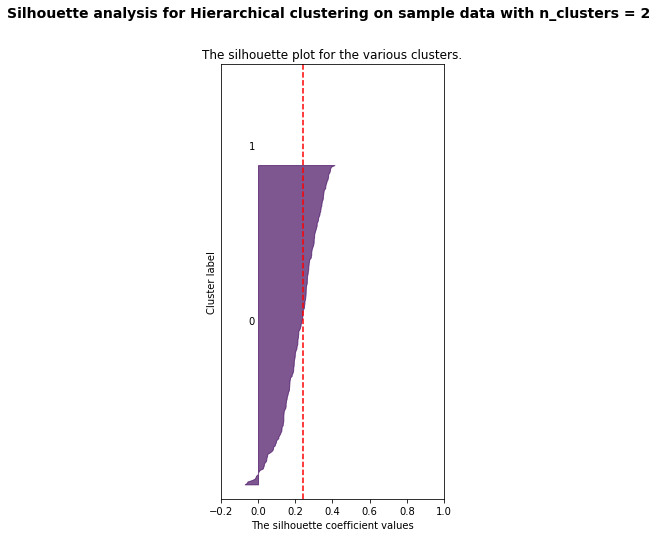

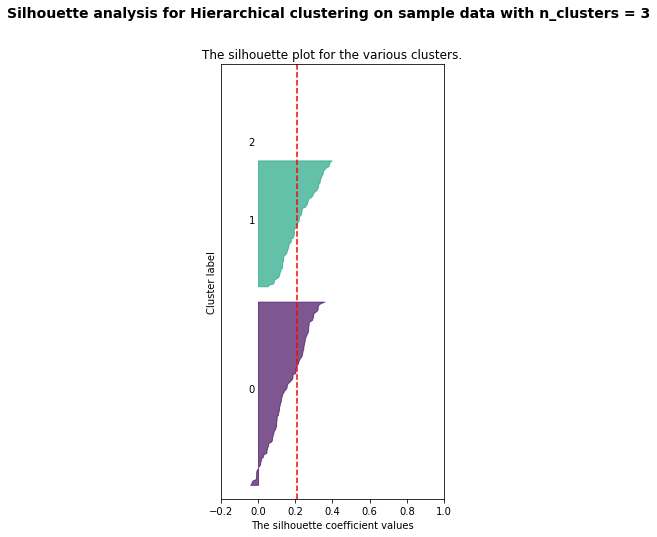

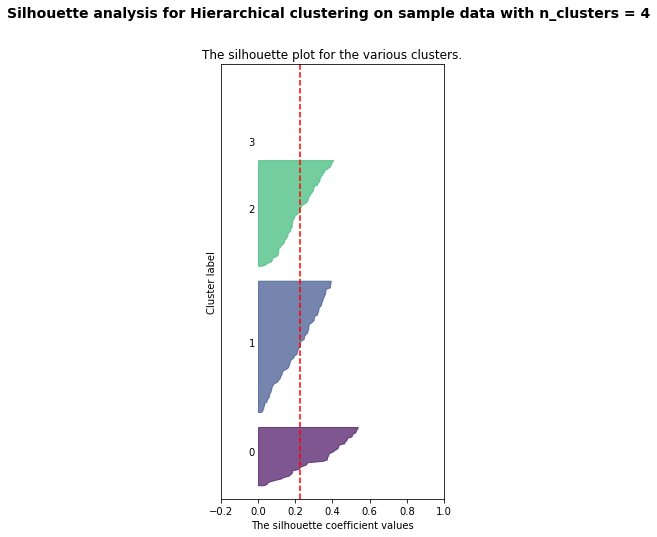

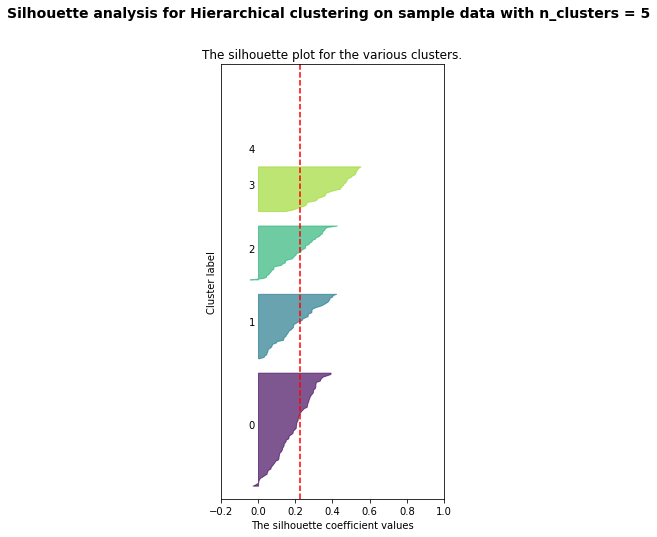

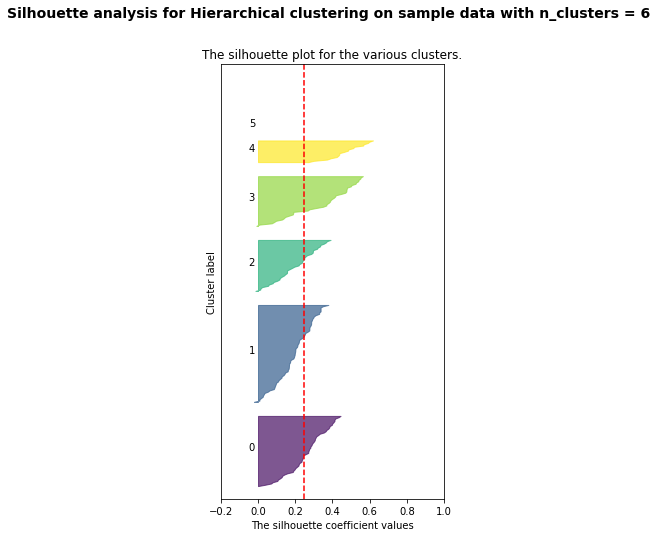

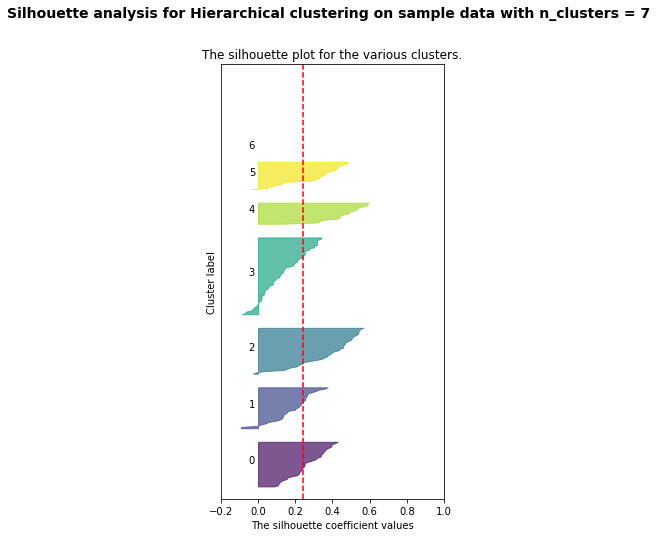

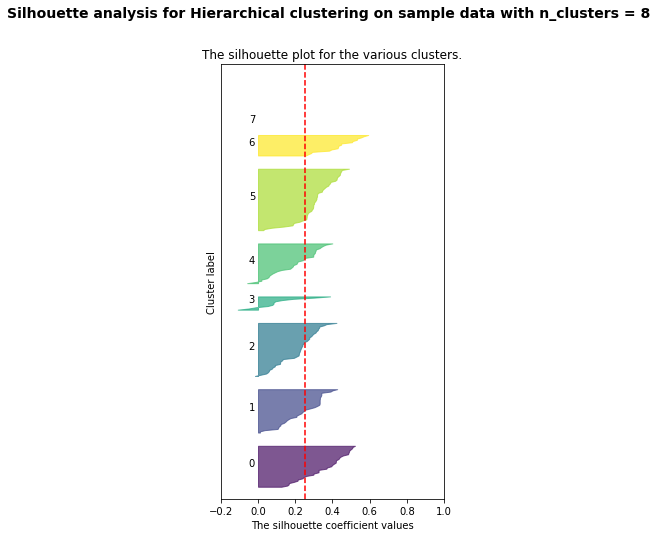

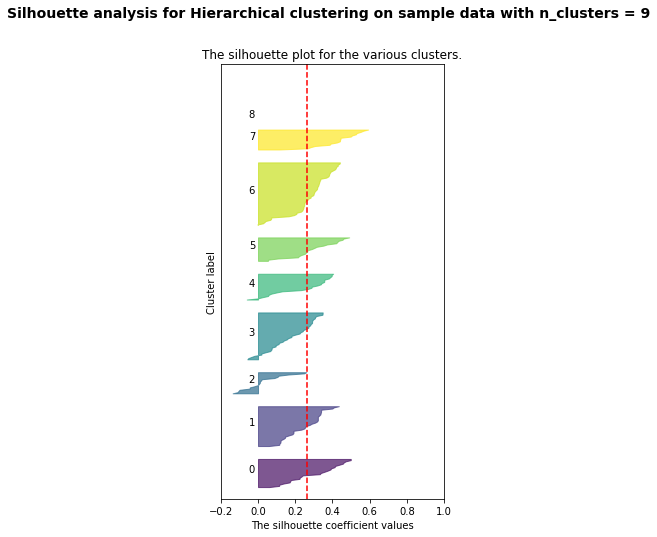

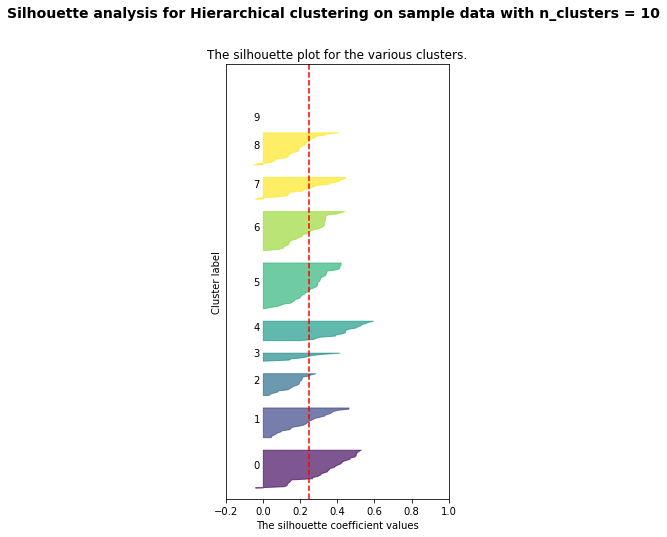

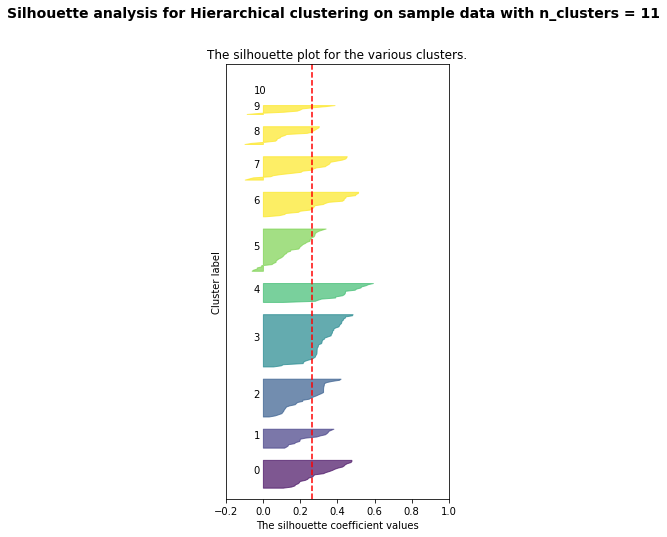

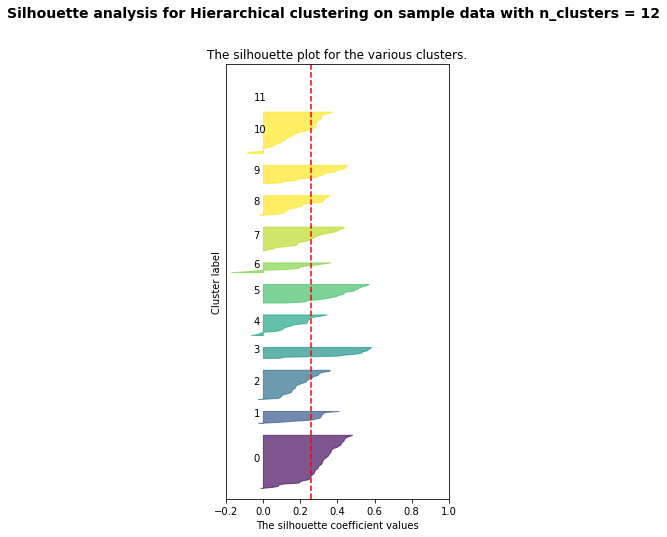

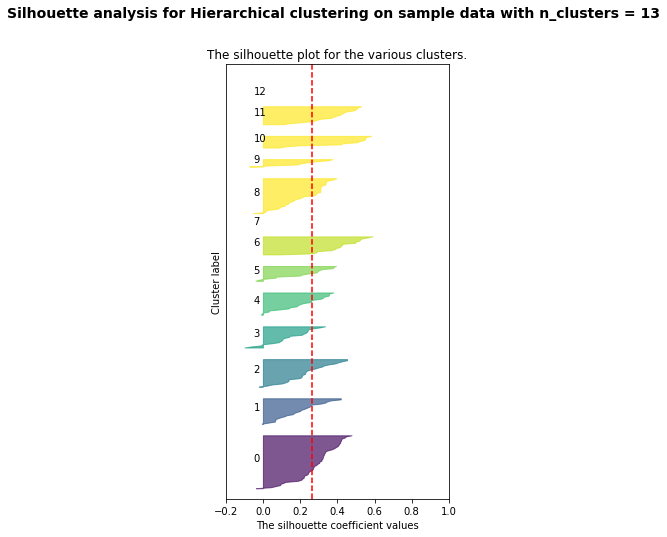

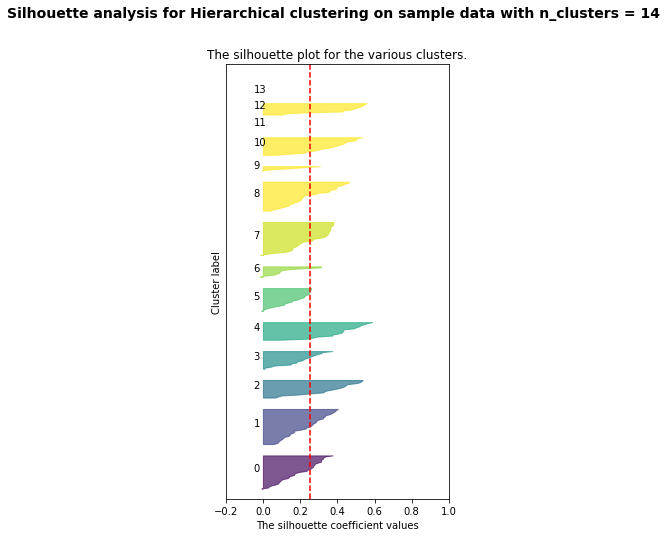

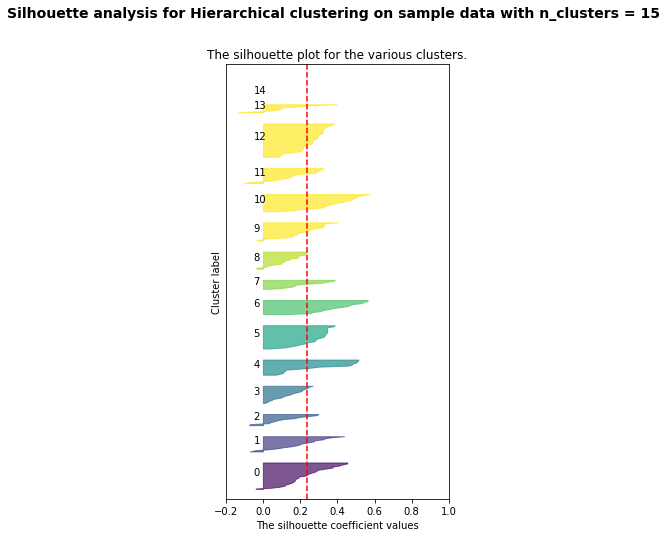

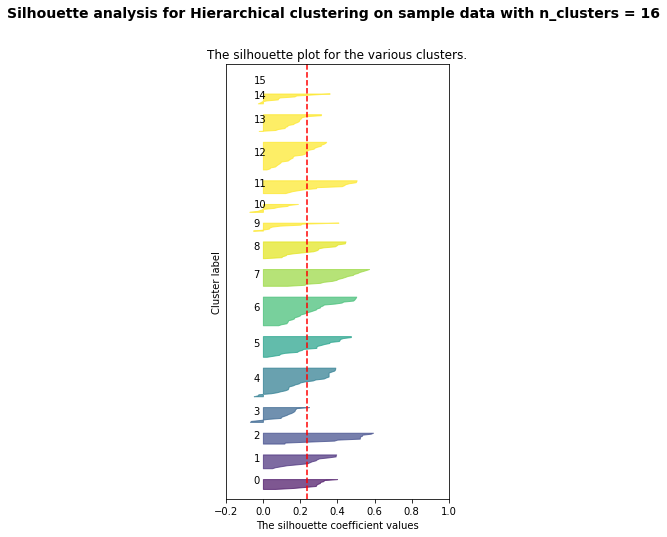

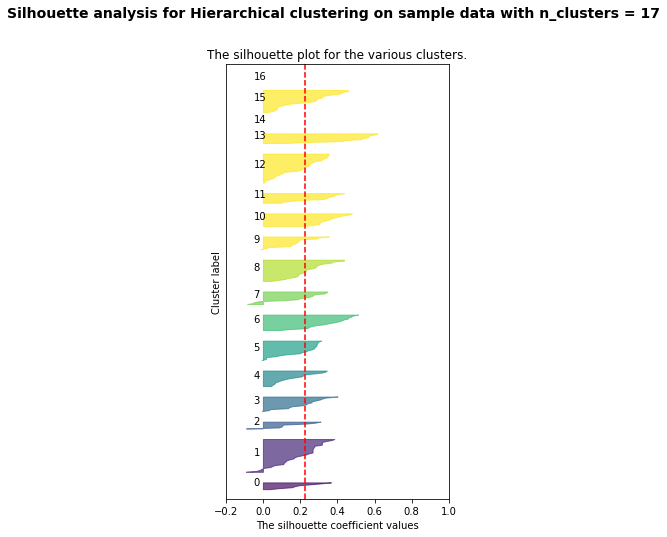

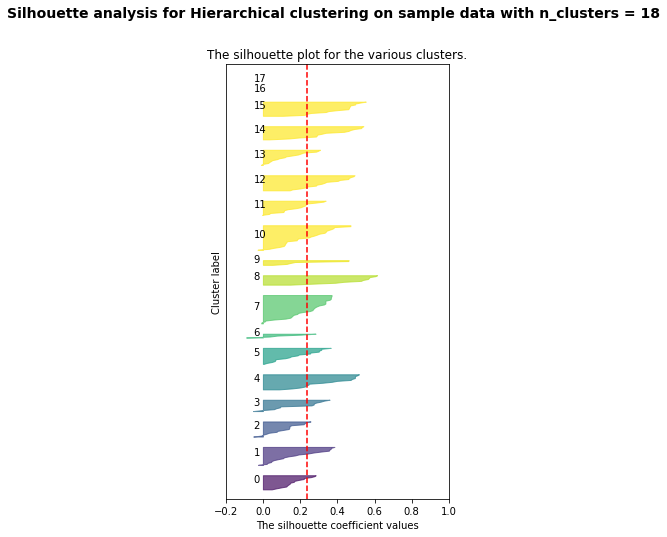

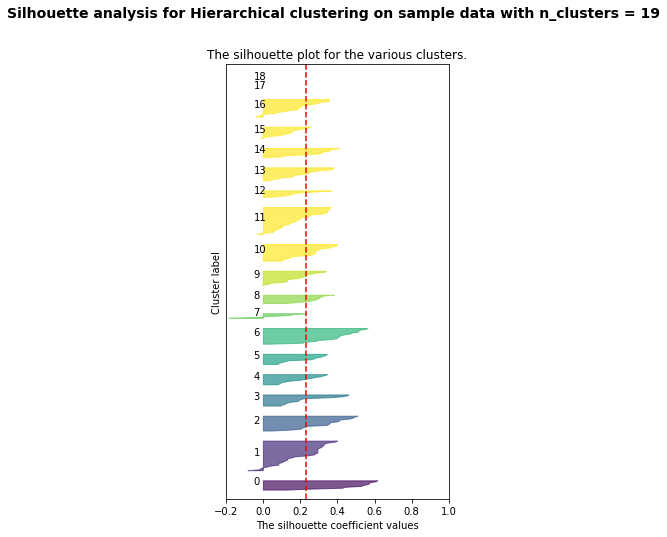

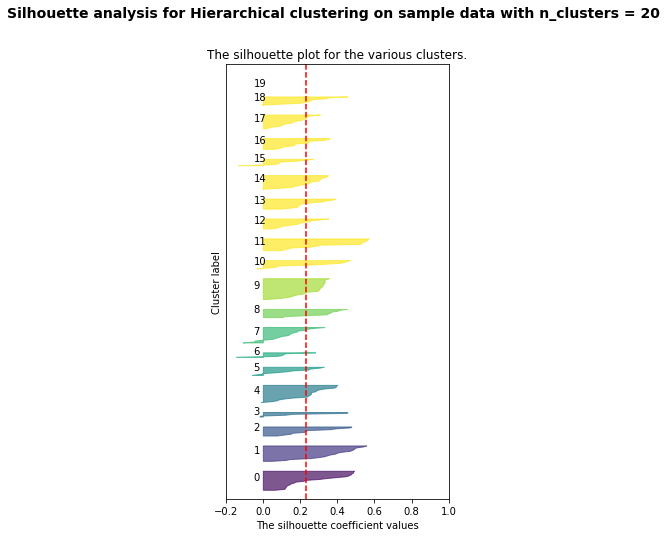

In [17]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.pyplot import spectral

nc = range(2,21)
scores = []
for n_clusters in nc:
    fig,ax = plt.subplots(1,1,figsize=(4,8))
    ax.set_xlim([-0.2,1])
    ax.set_ylim([0, len(df_without_categorical_values) + (n_clusters + 1) * 10])
    #kmeans = KMeans(n_clusters=n_clusters,random_state=0)
    #labels = kmeans.fit_predict(D)
    clusterer = KMeans (n_clusters=n_clusters)
    labels = clusterer.fit_predict(df_without_categorical_values)
    
    score = silhouette_score(df_without_categorical_values,labels)
    scores.append(score)
    sample_sil_values = silhouette_samples(df_without_categorical_values,labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        #For hierarchial clustering the cluster labelling start from 1. 
        
        ith_cluster_silhouette_values = \
            sample_sil_values[labels == i+1]
        
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.get_cmap('viridis')
        color = cmap(y_lower)
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=score, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()     

For n_clusters = 2, silhouette score is 0.3504666953926313)
For n_clusters = 3, silhouette score is 0.35013284339503314)
For n_clusters = 4, silhouette score is 0.40540630114085424)
For n_clusters = 5, silhouette score is 0.4431614235100357)
For n_clusters = 6, silhouette score is 0.4725527963695031)
For n_clusters = 7, silhouette score is 0.5155568348315748)
For n_clusters = 8, silhouette score is 0.5553020510639665)
For n_clusters = 9, silhouette score is 0.5776996081522724)
For n_clusters = 10, silhouette score is 0.6046820392234722)
For n_clusters = 11, silhouette score is 0.6131696302038362)
For n_clusters = 12, silhouette score is 0.603208854079653)
For n_clusters = 13, silhouette score is 0.5966300941710068)
For n_clusters = 14, silhouette score is 0.617069875902594)
For n_clusters = 15, silhouette score is 0.6178854420997643)
For n_clusters = 16, silhouette score is 0.5981796646997065)
For n_clusters = 17, silhouette score is 0.5018570329225973)
For n_clusters = 18, silhouette 

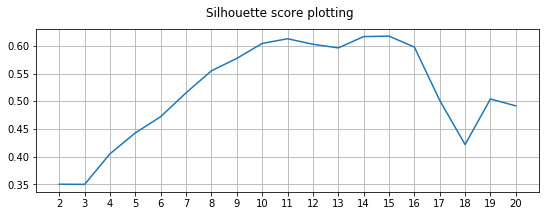

In [48]:
score_list = []
for n_clusters in range(2,21):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_with_catval_encoded)
    centers = clusterer.cluster_centers_

    score = silhouette_score (df_with_catval_encoded, preds, metric='euclidean')
    score_list.append(score)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
    
names = range(2,21)
values = score_list


plt.figure(figsize=(9, 3))

plt.subplot(111)
plt.plot(names, values)
plt.suptitle('Silhouette score plotting')
plt.grid(True)
plt.xticks(names)
plt.show()


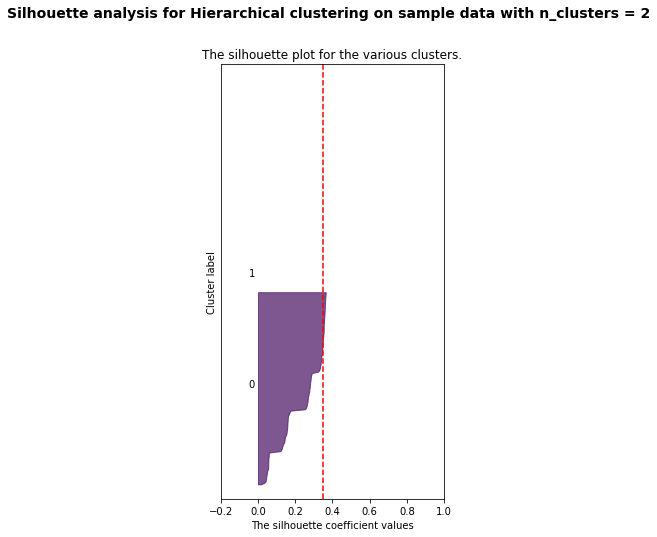

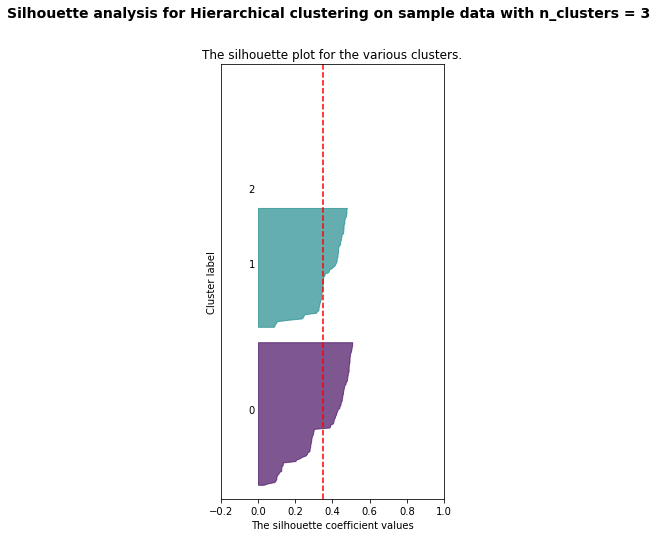

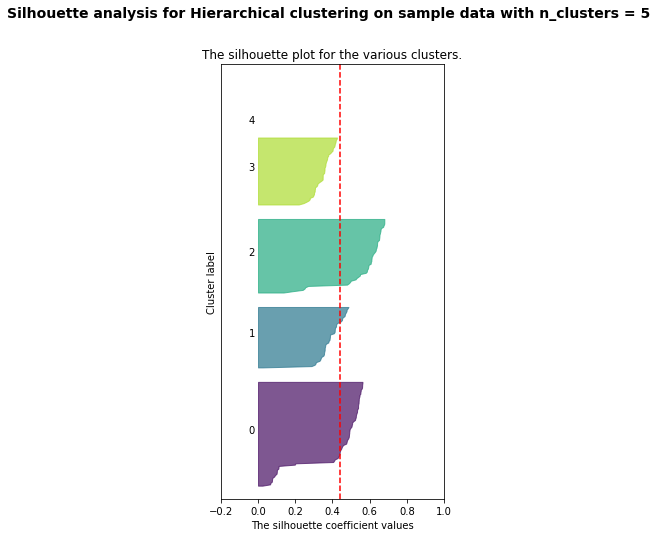

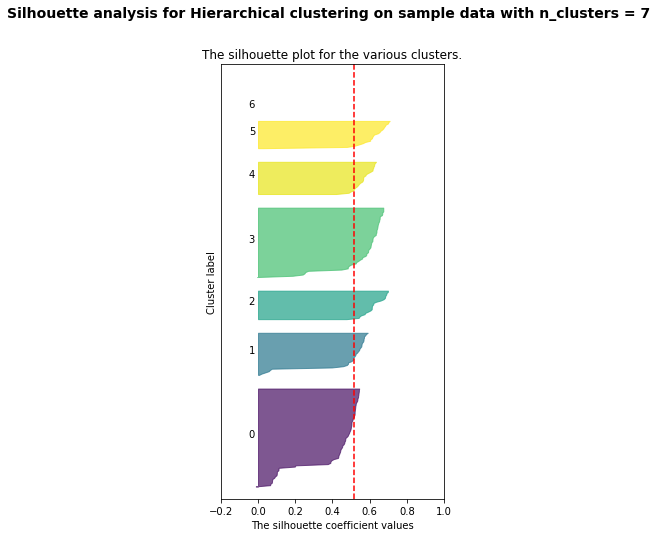

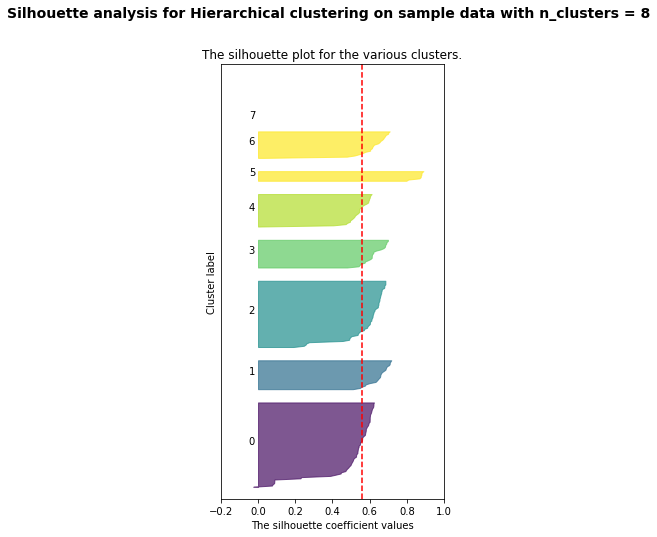

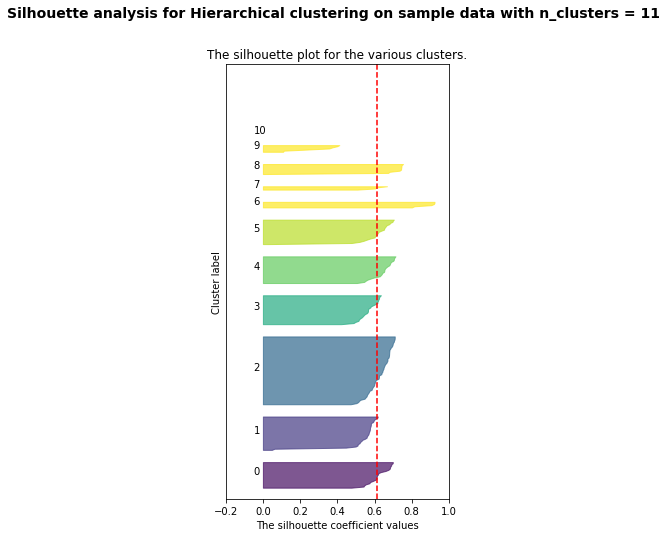

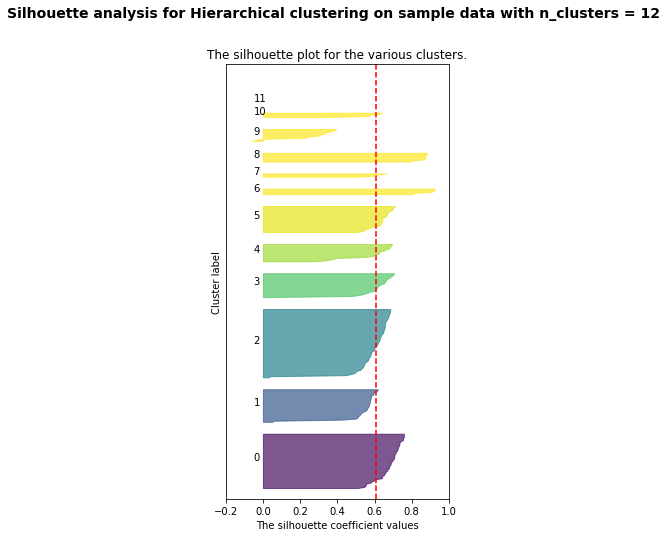

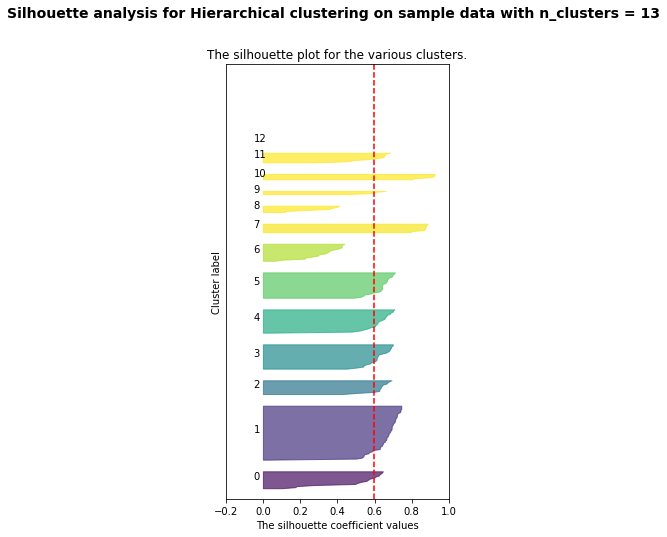

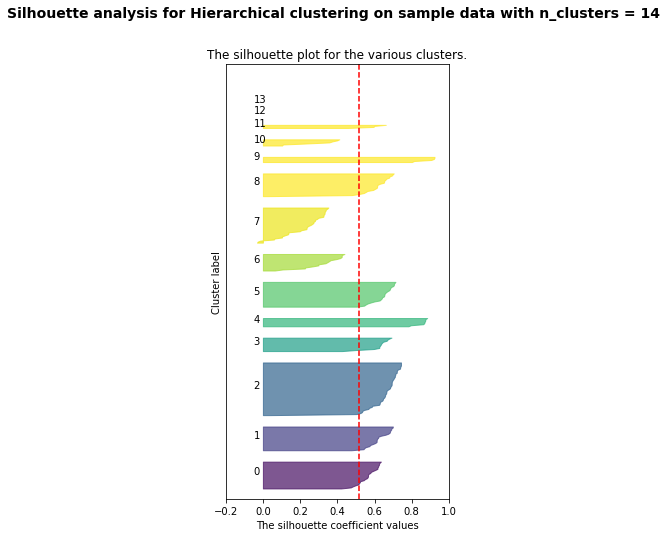

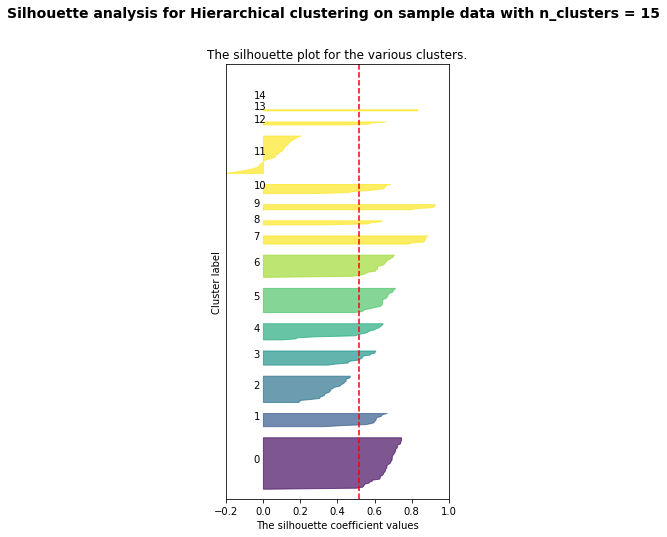

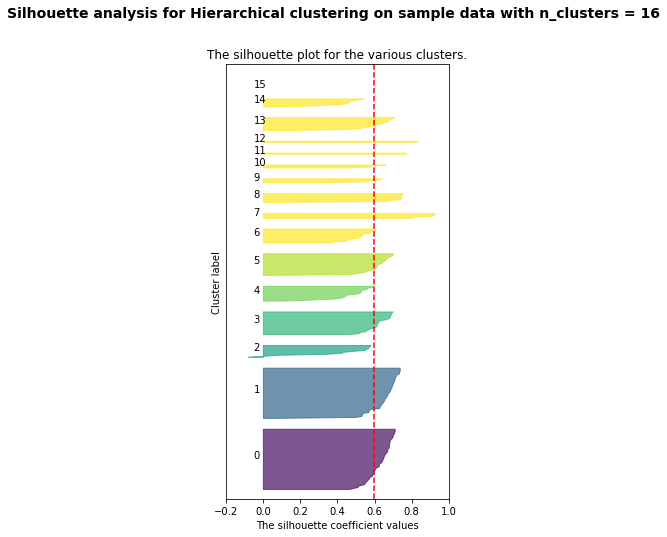

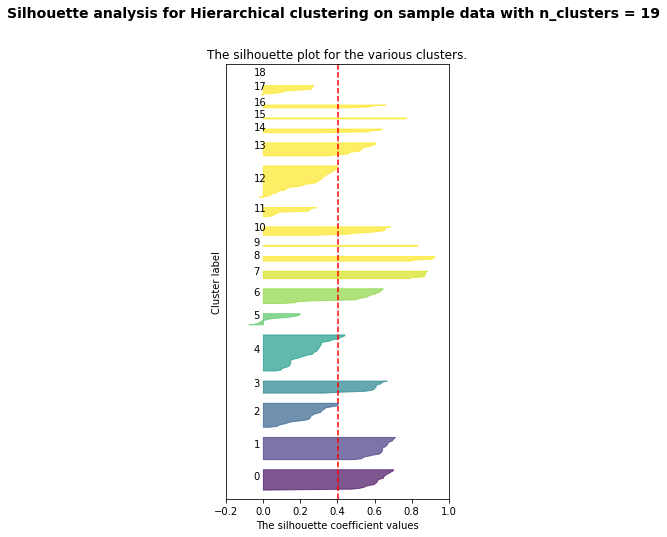

In [19]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.pyplot import spectral

nc = range(2,21)
scores = []
for n_clusters in nc:
    fig,ax = plt.subplots(1,1,figsize=(4,8))
    ax.set_xlim([-0.2,1])
    ax.set_ylim([0, len(df_with_catval_encoded) + (n_clusters + 1) * 10])
    #kmeans = KMeans(n_clusters=n_clusters,random_state=0)
    #labels = kmeans.fit_predict(D)
    clusterer = KMeans (n_clusters=n_clusters)
    labels = clusterer.fit_predict(df_with_catval_encoded)
    
    score = silhouette_score(df_with_catval_encoded,labels)
    scores.append(score)
    sample_sil_values = silhouette_samples(df_with_catval_encoded,labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        #For hierarchial clustering the cluster labelling start from 1. 
        
        ith_cluster_silhouette_values = \
            sample_sil_values[labels == i+1]
        
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.get_cmap('viridis')
        color = cmap(y_lower)
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=score, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()     

In [20]:
for n_clusters in range(2,20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(dataset_proj_tsne)
    centers = clusterer.cluster_centers_

    score = silhouette_score (dataset_proj_tsne, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5751049518585205)
For n_clusters = 3, silhouette score is 0.6281148791313171)
For n_clusters = 4, silhouette score is 0.6700077652931213)
For n_clusters = 5, silhouette score is 0.6849180459976196)
For n_clusters = 6, silhouette score is 0.7469090819358826)
For n_clusters = 7, silhouette score is 0.8051432371139526)
For n_clusters = 8, silhouette score is 0.7880120873451233)
For n_clusters = 9, silhouette score is 0.7843581438064575)
For n_clusters = 10, silhouette score is 0.739654541015625)
For n_clusters = 11, silhouette score is 0.6650651097297668)
For n_clusters = 12, silhouette score is 0.6873190402984619)
For n_clusters = 13, silhouette score is 0.6740267872810364)
For n_clusters = 14, silhouette score is 0.6791618466377258)
For n_clusters = 15, silhouette score is 0.6902530789375305)
For n_clusters = 16, silhouette score is 0.6600232720375061)
For n_clusters = 17, silhouette score is 0.6567521095275879)
For n_clusters = 18, silhouette s

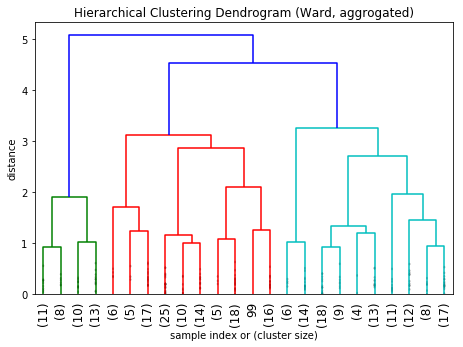

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(df_without_categorical_values, 'ward')
figure = plt.figure(figsize=(7.5, 5))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('Hierarchical Clustering Dendrogram (Ward, aggrogated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

Method: Hierarchical clustering
Percentage overlap with default clustering:0.683
Homogeneity: 0.758
Completeness: 0.787
V-measure: 0.772


Confusion matrix:


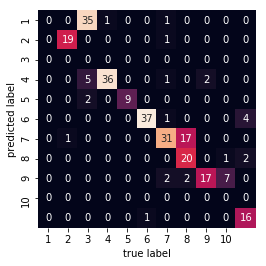

In [22]:
clusters = fcluster(linkage_matrix, kclust, criterion='maxclust')
show_output(clusters,target,'Hierarchical clustering', kclust)

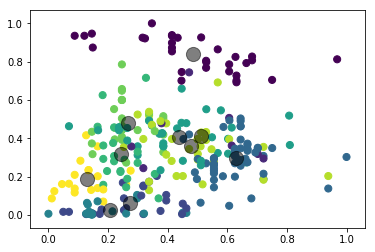

In [23]:
clusters, kmeans = kmeans_clust(kclust,df_without_categorical_values, 'full')
plot_clust(clusters, kmeans)

Method: KMeans
Percentage overlap with default clustering:0.756
Homogeneity: 0.696
Completeness: 0.723
V-measure: 0.709


Confusion matrix:


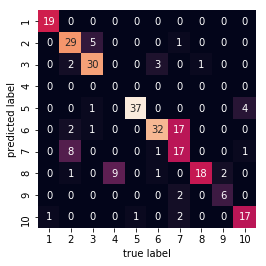

In [24]:
show_output(clusters,target,'KMeans', kclust)

Method: Kmeans with TSNE
Percentage overlap with default clustering:0.568
Homogeneity: 0.476
Completeness: 0.572
V-measure: 0.519


Confusion matrix:


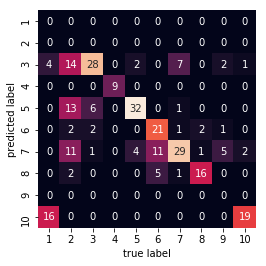

In [25]:
# Compute the clusters
kmeans = KMeans(n_clusters=kclust, random_state=0)
clusters = kmeans.fit_predict(dataset_proj_tsne)

show_output(clusters,target,'Kmeans with TSNE', kclust)

Method: Gaussian Mixture
Percentage overlap with default clustering:0.731
Homogeneity: 0.681
Completeness: 0.703
V-measure: 0.692


Confusion matrix:


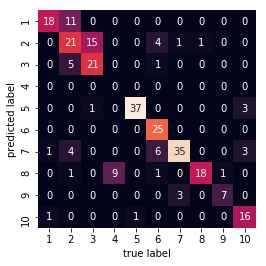

In [26]:
#Calculate cluster assumming that the datapoints in clusters are normally distributed
#Distance matrix is taken as the feature matrix 


gmm = GaussianMixture(n_components=kclust,covariance_type='full',random_state=7)
gmm.fit(df_without_categorical_values)
old_label = gmm.predict(df_without_categorical_values) 
#print(old_label)

show_output(old_label,target,'Gaussian Mixture', kclust)



Method: Gaussian Mixture with PCA
Percentage overlap with default clustering:0.601
Homogeneity: 0.510
Completeness: 0.639
V-measure: 0.568


Confusion matrix:


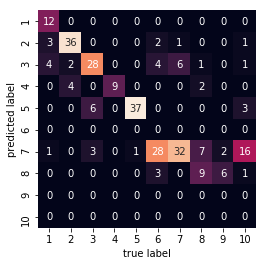

In [27]:
gmm = GaussianMixture(n_components=kclust,covariance_type='full',random_state=7)
gmm.fit(dataset_proj_pca)
old_label = gmm.predict(dataset_proj_pca) 
#print(old_label)

show_output(old_label,target,'Gaussian Mixture with PCA', kclust)

Method: Kmeans with PCA
Percentage overlap with default clustering:0.616
Homogeneity: 0.544
Completeness: 0.613
V-measure: 0.577


Confusion matrix:


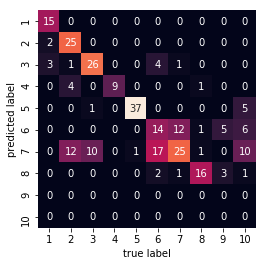

In [28]:
kmeans = KMeans(n_clusters=kclust, random_state=0)
clusters = kmeans.fit_predict(dataset_proj_pca)

show_output(clusters,target,'Kmeans with PCA', kclust)

Method: SpectralClustering
Percentage overlap with default clustering:0.845
Homogeneity: 0.746
Completeness: 0.776
V-measure: 0.761


Confusion matrix:


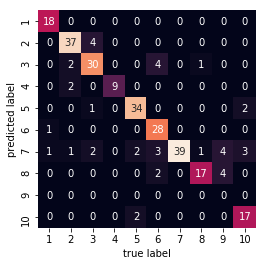

In [30]:
model = SpectralClustering(n_clusters=kclust, affinity='nearest_neighbors',
                           assign_labels='discretize')
clusters = model.fit_predict(df_without_categorical_values)
show_output(clusters,target,'SpectralClustering', kclust)

Method: SpectralClustering with tsne
Percentage overlap with default clustering:0.587
Homogeneity: 0.481
Completeness: 0.541
V-measure: 0.509


Confusion matrix:


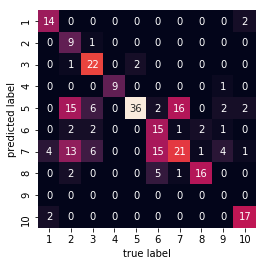

In [31]:
clusters = model.fit_predict(dataset_proj_tsne)
show_output(clusters,target,'SpectralClustering with tsne', kclust)

Method: SpectralClustering with pca
Percentage overlap with default clustering:0.620
Homogeneity: 0.530
Completeness: 0.634
V-measure: 0.577


Confusion matrix:


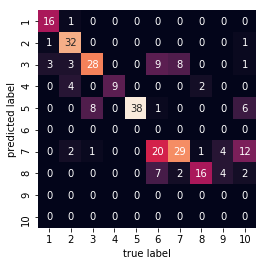

In [32]:
clusters = model.fit_predict(dataset_proj_pca)
show_output(clusters,target,'SpectralClustering with pca', kclust)

Method: AgglomerativeClustering
Percentage overlap with default clustering:0.812
Homogeneity: 0.758
Completeness: 0.787
V-measure: 0.772


Confusion matrix:


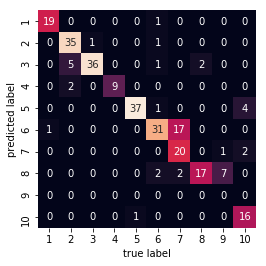

In [33]:
def doAgglomerative(inputData, nclust=kclust, aff='euclidean', link='ward'):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = aff, linkage = link)
    clust_labels1 = model.fit_predict(inputData)
    return (clust_labels1)

clusters = doAgglomerative(df_without_categorical_values, kclust)
show_output(clusters,target,'AgglomerativeClustering', kclust)

Method: AgglomerativeClustering with tsne
Percentage overlap with default clustering:0.568
Homogeneity: 0.476
Completeness: 0.572
V-measure: 0.519


Confusion matrix:


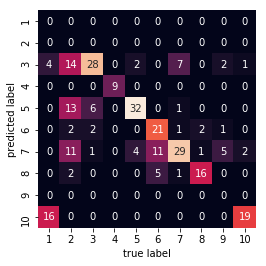

In [34]:
clusters = doAgglomerative(dataset_proj_tsne, kclust)
show_output(clusters,target,'AgglomerativeClustering with tsne', kclust)

In [35]:
df_with_catval_encoded.head()

SeedM        Wd       LMA     Nmass   Shade-T  Drought-T  Waterlog-T   \
0  0.415429  0.126453  0.154179  0.249081  0.898263   0.349076     0.005000   
1  0.208779  0.088058  0.111796  0.159412  1.000000   0.182752     0.250000   
2  0.357480  0.164848  0.133285  0.238702  0.831266   0.369610     0.005000   
3  0.233325  0.134575  0.133285  0.238702  0.909016   0.300479     0.086667   
4  0.233325  0.134575  0.133285  0.238702  0.771712   0.266940     0.142500   

   AM_N  AM_Y  ECM_Y  ECM_N  A.G_G  A.G_A  Disp_W  Disp_U  Disp_A  Disp_H  \
0   1.0   0.0    1.0    0.0    1.0    0.0     1.0     0.0     0.0     0.0   
1   1.0   0.0    1.0    0.0    1.0    0.0     1.0     0.0     0.0     0.0   
2   1.0   0.0    1.0    0.0    1.0    0.0     1.0     0.0     0.0     0.0   
3   1.0   0.0    1.0    0.0    1.0    0.0     1.0     0.0     0.0     0.0   
4   1.0   0.0    1.0    0.0    1.0    0.0     1.0     0.0     0.0     0.0   

   Disp_D  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [36]:
#DbScan is not adapted to our dataset, we know the number of clusters we want and that we have no noise points
X = df_with_catval_encoded
# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=8).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("V-measure: %0.3f" % metrics.v_measure_score(target, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(target, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(target, labels,
                                           average_method='arithmetic'))

Estimated number of clusters: 10
Estimated number of noise points: 67
V-measure: 0.557
Adjusted Rand Index: 0.280
Adjusted Mutual Information: 0.516


In [37]:
df_with_categorical_values.head()

SeedM        Wd         LMA     Nmass   Shade-T  Drought-T  Waterlog-T   \
0  1.834421  0.350000  185.611741  1.720000  4.600000   1.810000     1.020000   
1  0.934498  0.330000  143.000000  1.450000  5.010000   1.000000     2.000000   
2  1.582063  0.370000  164.604357  1.688749  4.330000   1.910000     1.020000   
3  1.041393  0.354231  164.604357  1.688749  4.643333   1.573333     1.346667   
4  1.041393  0.354231  164.604357  1.688749  4.090000   1.410000     1.570000   

  AM ECM A.G Disp  
0  N   Y   G    W  
1  N   Y   G    W  
2  N   Y   G    W  
3  N   Y   G    W  
4  N   Y   G    W

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 64, cost: 537.0
Run 1, iteration: 2/100, moves: 13, cost: 537.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 79, cost: 548.0
Run 2, iteration: 2/100, moves: 14, cost: 548.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 80, cost: 542.0
Run 3, iteration: 2/100, moves: 23, cost: 542.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 67, cost: 566.0
Run 4, iteration: 2/100, moves: 10, cost: 566.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 104, cost: 575.0
Run 5, iteration: 2/100, moves: 29, cost: 574.0
Run 5, iteration: 3/100, moves: 2, cost: 574.0
Init: initializing centroids
Init: initializing clusters
Starting iterat

Run 41, iteration: 3/100, moves: 2, cost: 541.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 42, iteration: 1/100, moves: 71, cost: 555.0
Run 42, iteration: 2/100, moves: 16, cost: 555.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 43, iteration: 1/100, moves: 66, cost: 585.0
Run 43, iteration: 2/100, moves: 45, cost: 562.0
Run 43, iteration: 3/100, moves: 8, cost: 562.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 44, iteration: 1/100, moves: 61, cost: 562.0
Run 44, iteration: 2/100, moves: 12, cost: 553.0
Run 44, iteration: 3/100, moves: 3, cost: 553.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 45, iteration: 1/100, moves: 85, cost: 568.0
Run 45, iteration: 2/100, moves: 5, cost: 568.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 46, iteration: 1/100, moves: 123, cost: 550.0
Run 46, iterati

Run 80, iteration: 2/100, moves: 36, cost: 559.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 81, iteration: 1/100, moves: 52, cost: 574.0
Run 81, iteration: 2/100, moves: 18, cost: 566.0
Run 81, iteration: 3/100, moves: 0, cost: 566.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 82, iteration: 1/100, moves: 54, cost: 564.0
Run 82, iteration: 2/100, moves: 7, cost: 564.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 83, iteration: 1/100, moves: 75, cost: 555.0
Run 83, iteration: 2/100, moves: 15, cost: 555.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 84, iteration: 1/100, moves: 46, cost: 624.0
Run 84, iteration: 2/100, moves: 21, cost: 609.0
Run 84, iteration: 3/100, moves: 2, cost: 609.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 85, iteration: 1/100, moves: 96, cost: 609.0
Run 85, iterati

Run 120, iteration: 2/100, moves: 3, cost: 563.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 121, iteration: 1/100, moves: 91, cost: 558.0
Run 121, iteration: 2/100, moves: 41, cost: 543.0
Run 121, iteration: 3/100, moves: 1, cost: 543.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 122, iteration: 1/100, moves: 85, cost: 571.0
Run 122, iteration: 2/100, moves: 6, cost: 571.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 123, iteration: 1/100, moves: 76, cost: 575.0
Run 123, iteration: 2/100, moves: 3, cost: 575.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 124, iteration: 1/100, moves: 96, cost: 562.0
Run 124, iteration: 2/100, moves: 27, cost: 562.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 125, iteration: 1/100, moves: 17, cost: 603.0
Run 125, iteration: 2/100, moves: 6, cost: 603.0
Init:

Run 161, iteration: 3/100, moves: 11, cost: 547.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 162, iteration: 1/100, moves: 78, cost: 583.0
Run 162, iteration: 2/100, moves: 50, cost: 557.0
Run 162, iteration: 3/100, moves: 12, cost: 557.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 163, iteration: 1/100, moves: 81, cost: 612.0
Run 163, iteration: 2/100, moves: 43, cost: 564.0
Run 163, iteration: 3/100, moves: 10, cost: 564.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 164, iteration: 1/100, moves: 41, cost: 612.0
Run 164, iteration: 2/100, moves: 25, cost: 600.0
Run 164, iteration: 3/100, moves: 51, cost: 550.0
Run 164, iteration: 4/100, moves: 20, cost: 550.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 165, iteration: 1/100, moves: 54, cost: 564.0
Run 165, iteration: 2/100, moves: 9, cost: 564.0
Init: initializing centroids
In

Init: initializing clusters
Starting iterations...
Run 202, iteration: 1/100, moves: 90, cost: 551.0
Run 202, iteration: 2/100, moves: 25, cost: 541.0
Run 202, iteration: 3/100, moves: 3, cost: 541.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 203, iteration: 1/100, moves: 56, cost: 593.0
Run 203, iteration: 2/100, moves: 15, cost: 593.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 204, iteration: 1/100, moves: 63, cost: 540.0
Run 204, iteration: 2/100, moves: 18, cost: 538.0
Run 204, iteration: 3/100, moves: 0, cost: 538.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 205, iteration: 1/100, moves: 105, cost: 589.0
Run 205, iteration: 2/100, moves: 20, cost: 583.0
Run 205, iteration: 3/100, moves: 5, cost: 583.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 206, iteration: 1/100, moves: 69, cost: 600.0
Run 206, iteration: 2/100, move

Starting iterations...
Run 240, iteration: 1/100, moves: 68, cost: 579.0
Run 240, iteration: 2/100, moves: 57, cost: 561.0
Run 240, iteration: 3/100, moves: 9, cost: 561.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 241, iteration: 1/100, moves: 83, cost: 554.0
Run 241, iteration: 2/100, moves: 27, cost: 554.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 242, iteration: 1/100, moves: 69, cost: 556.0
Run 242, iteration: 2/100, moves: 27, cost: 550.0
Run 242, iteration: 3/100, moves: 15, cost: 548.0
Run 242, iteration: 4/100, moves: 6, cost: 543.0
Run 242, iteration: 5/100, moves: 3, cost: 543.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 243, iteration: 1/100, moves: 66, cost: 587.0
Run 243, iteration: 2/100, moves: 22, cost: 567.0
Run 243, iteration: 3/100, moves: 40, cost: 557.0
Run 243, iteration: 4/100, moves: 12, cost: 557.0
Init: initializing centroids
Init: initi

Run 278, iteration: 3/100, moves: 2, cost: 596.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 279, iteration: 1/100, moves: 45, cost: 588.0
Run 279, iteration: 2/100, moves: 5, cost: 588.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 280, iteration: 1/100, moves: 80, cost: 559.0
Run 280, iteration: 2/100, moves: 8, cost: 559.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 281, iteration: 1/100, moves: 84, cost: 539.0
Run 281, iteration: 2/100, moves: 34, cost: 527.0
Run 281, iteration: 3/100, moves: 8, cost: 527.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 282, iteration: 1/100, moves: 5, cost: 685.0
Run 282, iteration: 2/100, moves: 0, cost: 685.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 283, iteration: 1/100, moves: 76, cost: 581.0
Run 283, iteration: 2/100, moves: 4, cost: 581.0
Init: i

Starting iterations...
Run 318, iteration: 1/100, moves: 90, cost: 582.0
Run 318, iteration: 2/100, moves: 30, cost: 553.0
Run 318, iteration: 3/100, moves: 16, cost: 546.0
Run 318, iteration: 4/100, moves: 7, cost: 546.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 319, iteration: 1/100, moves: 76, cost: 595.0
Run 319, iteration: 2/100, moves: 43, cost: 595.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 320, iteration: 1/100, moves: 70, cost: 556.0
Run 320, iteration: 2/100, moves: 32, cost: 546.0
Run 320, iteration: 3/100, moves: 9, cost: 546.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 321, iteration: 1/100, moves: 63, cost: 584.0
Run 321, iteration: 2/100, moves: 15, cost: 584.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 322, iteration: 1/100, moves: 80, cost: 570.0
Run 322, iteration: 2/100, moves: 24, cost: 558.0
Run 322, 

Run 356, iteration: 3/100, moves: 9, cost: 537.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 357, iteration: 1/100, moves: 87, cost: 570.0
Run 357, iteration: 2/100, moves: 11, cost: 564.0
Run 357, iteration: 3/100, moves: 1, cost: 564.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 358, iteration: 1/100, moves: 69, cost: 543.0
Run 358, iteration: 2/100, moves: 2, cost: 543.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 359, iteration: 1/100, moves: 95, cost: 556.0
Run 359, iteration: 2/100, moves: 11, cost: 556.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 360, iteration: 1/100, moves: 68, cost: 566.0
Run 360, iteration: 2/100, moves: 13, cost: 566.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 361, iteration: 1/100, moves: 77, cost: 613.0
Run 361, iteration: 2/100, moves: 9, cost: 610.0
Run 

Run 395, iteration: 2/100, moves: 26, cost: 550.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 396, iteration: 1/100, moves: 58, cost: 588.0
Run 396, iteration: 2/100, moves: 0, cost: 588.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 397, iteration: 1/100, moves: 72, cost: 531.0
Run 397, iteration: 2/100, moves: 7, cost: 531.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 398, iteration: 1/100, moves: 72, cost: 564.0
Run 398, iteration: 2/100, moves: 27, cost: 559.0
Run 398, iteration: 3/100, moves: 0, cost: 559.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 399, iteration: 1/100, moves: 85, cost: 547.0
Run 399, iteration: 2/100, moves: 30, cost: 542.0
Run 399, iteration: 3/100, moves: 8, cost: 542.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 400, iteration: 1/100, moves: 26, cost: 649.0
Run 

Run 435, iteration: 2/100, moves: 27, cost: 572.0
Run 435, iteration: 3/100, moves: 3, cost: 572.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 436, iteration: 1/100, moves: 59, cost: 566.0
Run 436, iteration: 2/100, moves: 16, cost: 561.0
Run 436, iteration: 3/100, moves: 10, cost: 561.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 437, iteration: 1/100, moves: 42, cost: 641.0
Run 437, iteration: 2/100, moves: 2, cost: 641.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 438, iteration: 1/100, moves: 88, cost: 555.0
Run 438, iteration: 2/100, moves: 30, cost: 550.0
Run 438, iteration: 3/100, moves: 5, cost: 545.0
Run 438, iteration: 4/100, moves: 4, cost: 545.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 439, iteration: 1/100, moves: 81, cost: 581.0
Run 439, iteration: 2/100, moves: 40, cost: 575.0
Run 439, iteration: 3/100, moves: 

Starting iterations...
Run 473, iteration: 1/100, moves: 86, cost: 573.0
Run 473, iteration: 2/100, moves: 43, cost: 573.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 474, iteration: 1/100, moves: 63, cost: 556.0
Run 474, iteration: 2/100, moves: 19, cost: 558.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 475, iteration: 1/100, moves: 54, cost: 601.0
Run 475, iteration: 2/100, moves: 8, cost: 601.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 476, iteration: 1/100, moves: 94, cost: 542.0
Run 476, iteration: 2/100, moves: 41, cost: 542.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 477, iteration: 1/100, moves: 52, cost: 576.0
Run 477, iteration: 2/100, moves: 1, cost: 576.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 478, iteration: 1/100, moves: 83, cost: 576.0
Run 478, iteration: 2/100, mo

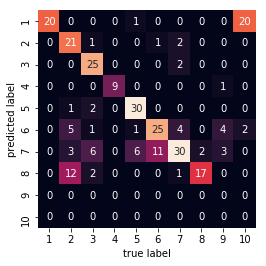

In [38]:
km = KModes(n_clusters=kclust, init='Huang', n_init=500, verbose=2)

clusters = km.fit_predict(df_all_cat)

# Print the cluster centroids
#print(km.cluster_centroids_)
show_output(clusters,target,'KModes', kclust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 108, ncost: 43.93117262572447
Run: 1, iteration: 2/100, moves: 31, ncost: 41.622367372509935
Run: 1, iteration: 3/100, moves: 13, ncost: 41.3072683312178
Run: 1, iteration: 4/100, moves: 3, ncost: 41.231616067311926
Run: 1, iteration: 5/100, moves: 8, ncost: 40.474468807357326
Run: 1, iteration: 6/100, moves: 3, ncost: 40.322461906487966
Run: 1, iteration: 7/100, moves: 2, ncost: 40.2325147356758
Run: 1, iteration: 8/100, moves: 2, ncost: 40.184781761772186
Run: 1, iteration: 9/100, moves: 1, ncost: 40.1504819565385
Run: 1, iteration: 10/100, moves: 0, ncost: 40.1504819565385
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 110, ncost: 45.29176376142289
Run: 2, iteration: 2/100, moves: 45, ncost: 42.69271443878302
Run: 2, iteration: 3/100, moves: 14, ncost: 42.233498354192854
Run: 2, iteration: 4/100, moves: 9, 

Run: 21, iteration: 1/100, moves: 85, ncost: 40.83282783404193
Run: 21, iteration: 2/100, moves: 12, ncost: 40.482960116697114
Run: 21, iteration: 3/100, moves: 0, ncost: 40.482960116697114
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 22, iteration: 1/100, moves: 97, ncost: 47.57396834782846
Run: 22, iteration: 2/100, moves: 38, ncost: 44.718292826693364
Run: 22, iteration: 3/100, moves: 20, ncost: 43.96938644510706
Run: 22, iteration: 4/100, moves: 2, ncost: 43.94459914860424
Run: 22, iteration: 5/100, moves: 0, ncost: 43.94459914860424
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 23, iteration: 1/100, moves: 120, ncost: 47.28957509239886
Run: 23, iteration: 2/100, moves: 27, ncost: 46.49210619847342
Run: 23, iteration: 3/100, moves: 4, ncost: 46.41076988858426
Run: 23, iteration: 4/100, moves: 2, ncost: 46.3940799127806
Run: 23, iteration: 5/100, moves: 0, ncost: 46.3940799127806
Init: initializing centro

Run: 38, iteration: 5/100, moves: 0, ncost: 42.884008520325956
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 39, iteration: 1/100, moves: 120, ncost: 45.26574180156975
Run: 39, iteration: 2/100, moves: 33, ncost: 43.634069589015816
Run: 39, iteration: 3/100, moves: 14, ncost: 42.300558214782185
Run: 39, iteration: 4/100, moves: 8, ncost: 42.061842906758315
Run: 39, iteration: 5/100, moves: 1, ncost: 42.050941411660965
Run: 39, iteration: 6/100, moves: 0, ncost: 42.050941411660965
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 40, iteration: 1/100, moves: 125, ncost: 45.85497308879856
Run: 40, iteration: 2/100, moves: 42, ncost: 42.91026142487468
Run: 40, iteration: 3/100, moves: 15, ncost: 42.21613856394615
Run: 40, iteration: 4/100, moves: 10, ncost: 40.457682142812175
Run: 40, iteration: 5/100, moves: 9, ncost: 39.90220446152977
Run: 40, iteration: 6/100, moves: 1, ncost: 39.891857309068925
Run: 40, iteratio

Run: 58, iteration: 2/100, moves: 63, ncost: 44.59202958724956
Run: 58, iteration: 3/100, moves: 21, ncost: 43.35076096800872
Run: 58, iteration: 4/100, moves: 8, ncost: 43.108029954457166
Run: 58, iteration: 5/100, moves: 1, ncost: 43.101165482041
Run: 58, iteration: 6/100, moves: 0, ncost: 43.101165482041
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 59, iteration: 1/100, moves: 88, ncost: 44.910504817095
Run: 59, iteration: 2/100, moves: 16, ncost: 44.43000231919323
Run: 59, iteration: 3/100, moves: 6, ncost: 44.28336601524632
Run: 59, iteration: 4/100, moves: 2, ncost: 44.24594723394362
Run: 59, iteration: 5/100, moves: 0, ncost: 44.24594723394362
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 60, iteration: 1/100, moves: 97, ncost: 44.37

Starting iterations...
Run: 78, iteration: 1/100, moves: 115, ncost: 44.05493186057155
Run: 78, iteration: 2/100, moves: 20, ncost: 42.55868709965154
Run: 78, iteration: 3/100, moves: 1, ncost: 42.507350024366374
Run: 78, iteration: 4/100, moves: 0, ncost: 42.507350024366374
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 79, iteration: 1/100, moves: 107, ncost: 43.37068359978716
Run: 79, iteration: 2/100, moves: 19, ncost: 42.74691918772708
Run: 79, iteration: 3/100, moves: 4, ncost: 42.690644161036495
Run: 79, iteration: 4/100, moves: 3, ncost: 41.83955697381464
Run: 79, iteration: 5/100, moves: 13, ncost: 40.977211179350796
Run: 79, iteration: 6/100, moves: 8, ncost: 40.57598542879381
Run: 79, iteration: 7/100, moves: 4, ncost: 40.49597111094609
Run: 79, iteration: 8/100, moves: 0, ncost: 40.49597111094609
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 

Run: 96, iteration: 4/100, moves: 5, ncost: 41.999861269488505
Run: 96, iteration: 5/100, moves: 2, ncost: 41.982093797286026
Run: 96, iteration: 6/100, moves: 0, ncost: 41.982093797286026
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 97, iteration: 1/100, moves: 131, ncost: 45.68226799172759
Run: 97, iteration: 2/100, moves: 44, ncost: 43.1836425889539
Run: 97, iteration: 3/100, moves: 16, ncost: 42.6313787507622
Run: 97, iteration: 4/100, moves: 11, ncost: 42.371036765506055
Run: 97, iteration: 5/100, moves: 4, ncost: 41.377208709170844
Run: 97, iteration: 6/100, moves: 7, ncost: 40.95227512878297
Run: 97, iteration: 7/100, moves: 4, ncost: 40.894863371002415
Run: 97, iteration: 8/100, moves: 0, ncost: 40.894863371002415
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 98, iteration: 1/100, moves: 83, ncost: 47.09838568301355
Run: 98, iteration: 2/100, moves: 21, ncost: 46.19039769237185
Run: 98, iteration: 3/

Run: 115, iteration: 2/100, moves: 55, ncost: 43.35996604213067
Run: 115, iteration: 3/100, moves: 48, ncost: 40.29398766675551
Run: 115, iteration: 4/100, moves: 13, ncost: 40.054476563088436
Run: 115, iteration: 5/100, moves: 1, ncost: 40.03362965511485
Run: 115, iteration: 6/100, moves: 1, ncost: 40.020721267200976
Run: 115, iteration: 7/100, moves: 0, ncost: 40.020721267200976
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 116, iteration: 1/100, moves: 105, ncost: 40.620985430063556
Run: 116, iteration: 2/100, moves: 24, ncost: 39.673904071029376
Run: 116, iteration: 3/100, moves: 5, ncost: 39.616467313715646
Run: 116, iteration: 4/100, moves: 0, ncost: 39.616467313715646
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 117, iteration: 1/100, moves: 101, ncost: 41.91893268978489
Run: 117, iteration: 2/100, moves: 28, ncost: 40.939876200500656
Run: 117, iteration: 3/100, moves: 0, ncost: 40.939876200500656
Ini

Run: 131, iteration: 7/100, moves: 6, ncost: 43.06718504007634
Run: 131, iteration: 8/100, moves: 6, ncost: 42.99271123841147
Run: 131, iteration: 9/100, moves: 1, ncost: 42.98752738686057
Run: 131, iteration: 10/100, moves: 0, ncost: 42.98752738686057
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 132, iteration: 1/100, moves: 106, ncost: 41.423373415362356
Run: 132, iteration: 2/100, moves: 27, ncost: 40.546160889517715
Run: 132, iteration: 3/100, moves: 5, ncost: 40.46299328227219
Run: 132, iteration: 4/100, moves: 1, ncost: 40.45667235486102
Run: 132, iteration: 5/100, moves: 1, ncost: 40.45156191825037
Run: 132, iteration: 6/100, moves: 0, ncost: 40.45156191825037
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 133, iteration: 1/100, moves: 111, ncost: 49.11966288992201
Run: 133, iteration: 2/100, moves: 36, ncost: 46.484879153460575
Run: 133, iteration: 3/100, moves: 15, ncost: 46.11898549985912
Run: 133, 

Run: 149, iteration: 3/100, moves: 9, ncost: 41.67136365139771
Run: 149, iteration: 4/100, moves: 1, ncost: 41.65392477250456
Run: 149, iteration: 5/100, moves: 2, ncost: 41.63335881839708
Run: 149, iteration: 6/100, moves: 0, ncost: 41.63335881839708
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 150, iteration: 1/100, moves: 94, ncost: 45.50155202738719
Run: 150, iteration: 2/100, moves: 52, ncost: 43.34281831774823
Run: 150, iteration: 3/100, moves: 8, ncost: 43.22802597737431
Run: 150, iteration: 4/100, moves: 4, ncost: 43.06810183558696
Run: 150, iteration: 5/100, moves: 7, ncost: 42.77035185895103
Run: 150, iteration: 6/100, moves: 2, ncost: 42.70874601398453
Run: 150, iteration: 7/100, moves: 0, ncost: 42.70874601398453
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 151, iteration: 1/100, moves: 118, ncost: 44.91166753007644
Run: 151, iteration: 2/100, moves: 24, ncost: 43.28748653356148
Run: 151, iterat

Run: 166, iteration: 8/100, moves: 1, ncost: 41.000807609909145
Run: 166, iteration: 9/100, moves: 1, ncost: 40.9933845302098
Run: 166, iteration: 10/100, moves: 0, ncost: 40.9933845302098
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 167, iteration: 1/100, moves: 112, ncost: 43.00794332051019
Run: 167, iteration: 2/100, moves: 21, ncost: 40.81351410705633
Run: 167, iteration: 3/100, moves: 11, ncost: 40.42083937847796
Run: 167, iteration: 4/100, moves: 1, ncost: 40.40448442640233
Run: 167, iteration: 5/100, moves: 1, ncost: 40.38932387116185
Run: 167, iteration: 6/100, moves: 0, ncost: 40.38932387116185
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 168, iteration: 1/100, moves: 71, ncost: 45.71672078847554
Run: 168, iteration: 2/100, moves: 16, ncost: 44.928539197223905
Run: 168, iteration: 3/100, moves: 10, ncost: 44.55688168640382
Run: 168, iteration: 4/100, moves: 5, ncost: 44.37695570742722
Run: 168, ite

Run: 186, iteration: 3/100, moves: 3, ncost: 41.321853964895865
Run: 186, iteration: 4/100, moves: 2, ncost: 41.235018175072405
Run: 186, iteration: 5/100, moves: 2, ncost: 41.17847541688866
Run: 186, iteration: 6/100, moves: 0, ncost: 41.17847541688866
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 187, iteration: 1/100, moves: 101, ncost: 45.23638293079784
Run: 187, iteration: 2/100, moves: 34, ncost: 44.1037483253117
Run: 187, iteration: 3/100, moves: 5, ncost: 44.042077878842605
Run: 187, iteration: 4/100, moves: 0, ncost: 44.042077878842605
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 188, iteration: 1/100, moves: 83, ncost: 53.343269007497994
Run: 188, iteration: 2/100, moves: 29, ncost: 52.04989989413004
Run: 188, iteration: 3/100, moves: 20, ncost: 49.729817950918495
Run: 188, iteration: 4/100, moves: 34, ncost: 46.64671946205386
Run: 188, iteration: 5/100, moves: 10, ncost: 46.36169464462268
Run: 188

Run: 203, iteration: 1/100, moves: 137, ncost: 45.54162299653004
Run: 203, iteration: 2/100, moves: 36, ncost: 42.549713891633445
Run: 203, iteration: 3/100, moves: 20, ncost: 41.54724342568243
Run: 203, iteration: 4/100, moves: 10, ncost: 41.33428301932768
Run: 203, iteration: 5/100, moves: 2, ncost: 41.28405358374943
Run: 203, iteration: 6/100, moves: 0, ncost: 41.28405358374943
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 204, iteration: 1/100, moves: 100, ncost: 49.37956339784482
Run: 204, iteration: 2/100, moves: 67, ncost: 43.616143101632474
Run: 204, iteration: 3/100, moves: 19, ncost: 42.469377288889646
Run: 204, iteration: 4/100, moves: 2, ncost: 42.43266517583617
Run: 204, iteration: 5/100, moves: 4, ncost: 42.17019053163687
Run: 204, iteration: 6/100, moves: 3, ncost: 42.07121099941998
Run: 204, iteration: 7/100, moves: 2, ncost: 41.57809312948696
Run: 204, iteration: 8/100, moves: 5, ncost: 41.53243285913646
Run: 204, iteration: 9/100

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 222, iteration: 1/100, moves: 122, ncost: 47.323999109680784
Run: 222, iteration: 2/100, moves: 39, ncost: 45.21543464178612
Run: 222, iteration: 3/100, moves: 9, ncost: 44.878741720334595
Run: 222, iteration: 4/100, moves: 6, ncost: 44.77195502106632
Run: 222, iteration: 5/100, moves: 0, ncost: 44.77195502106632
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 223, iteration: 1/100, moves: 87, ncost: 46.321693559650804
Run: 223, iteration: 2/100, moves: 22, ncost: 45.55168089426479
Run: 223, iteration: 3/100, moves: 6, ncost: 44.869750419047286
Run: 223, iteration: 4/100, moves: 12, ncost: 44.372353892879204
Run: 223, iteration: 5/100, moves: 6, ncost: 44.14852898487561
Run: 223, iteration: 6/100, moves: 5, ncost: 43.89723717048698
Run: 223, iteration: 7/100, moves: 3, ncost: 43.72437660359865
Run: 223, iteration: 8/100, moves: 1, ncost: 43.69280094866254
Run: 223, 

Run: 240, iteration: 3/100, moves: 28, ncost: 41.70007499521944
Run: 240, iteration: 4/100, moves: 10, ncost: 41.33695486574754
Run: 240, iteration: 5/100, moves: 1, ncost: 41.329561531836546
Run: 240, iteration: 6/100, moves: 0, ncost: 41.329561531836546
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 241, iteration: 1/100, moves: 98, ncost: 44.606633665686346
Run: 241, iteration: 2/100, moves: 30, ncost: 42.89990468595717
Run: 241, iteration: 3/100, moves: 11, ncost: 42.62889559714822
Run: 241, iteration: 4/100, moves: 3, ncost: 42.58491034955295
Run: 241, iteration: 5/100, moves: 1, ncost: 42.57662805238125
Run: 241, iteration: 6/100, moves: 0, ncost: 42.57662805238125
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 242, iteration: 1/100, moves: 91, ncost: 44.86273997916361
Run: 242, iteration: 2/100, moves: 39, ncost: 42.63909799089057
Run: 242, iterati

Run: 258, iteration: 3/100, moves: 3, ncost: 45.28389231381726
Run: 258, iteration: 4/100, moves: 1, ncost: 45.278553209490376
Run: 258, iteration: 5/100, moves: 0, ncost: 45.278553209490376
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 259, iteration: 1/100, moves: 70, ncost: 49.458580872014636
Run: 259, iteration: 2/100, moves: 33, ncost: 45.27218022092885
Run: 259, iteration: 3/100, moves: 7, ncost: 45.11161862148011
Run: 259, iteration: 4/100, moves: 0, ncost: 45.11161862148011
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 260, iteration: 1/100, moves: 85, ncost: 51.650202390038565
Run: 260, iteration: 2/100, moves: 22, ncost: 50.1322709492429
Run: 260, iteration: 3/100, moves: 5, ncost: 49.80001525778722
Run: 260, iteration: 4/100, moves: 2, ncost: 49.75036187356059
Run: 260, iteration: 5/100, moves: 1, ncost: 49.71577130489437
Run: 260, iteration: 6/100, moves: 0, ncost: 49.71577130489437
Init: initiali

Starting iterations...
Run: 278, iteration: 1/100, moves: 91, ncost: 48.49331716843041
Run: 278, iteration: 2/100, moves: 38, ncost: 45.452517167074404
Run: 278, iteration: 3/100, moves: 2, ncost: 45.43307479354217
Run: 278, iteration: 4/100, moves: 0, ncost: 45.43307479354217
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 279, iteration: 1/100, moves: 105, ncost: 45.10029202981136
Run: 279, iteration: 2/100, moves: 47, ncost: 42.61880080218754
Run: 279, iteration: 3/100, moves: 8, ncost: 42.460423184159225
Run: 279, iteration: 4/100, moves: 1, ncost: 42.43268881124689
Run: 279, iteration: 5/100, moves: 1, ncost: 42.41249026892804
Run: 279, iteration: 6/100, moves: 1, ncost: 42.39472271605595
Run: 279, iteration: 7/100, moves: 0, ncost: 42.39472271605595
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 280, iteration: 1/100, moves: 121, ncost: 41.9283604073

Run: 297, iteration: 7/100, moves: 2, ncost: 42.80829898666029
Run: 297, iteration: 8/100, moves: 1, ncost: 42.78194420951504
Run: 297, iteration: 9/100, moves: 0, ncost: 42.78194420951504
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 298, iteration: 1/100, moves: 98, ncost: 45.740190446231765
Run: 298, iteration: 2/100, moves: 46, ncost: 42.39571406168346
Run: 298, iteration: 3/100, moves: 11, ncost: 41.72677539611246
Run: 298, iteration: 4/100, moves: 1, ncost: 41.71712624218537
Run: 298, iteration: 5/100, moves: 0, ncost: 41.71712624218537
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 299, iteration: 1/100, moves: 86, ncost: 49.79424902969293
Run: 299, iteration: 2/100, moves: 43, ncost: 47.48622234504424
Run: 299, iteration: 3/100, moves: 37, ncost: 45.48620108461219
Run: 299, iteration: 4/100, moves: 21, ncost: 44.020502655993326
Run: 299, iteratio

Run: 316, iteration: 5/100, moves: 9, ncost: 45.9285655248006
Run: 316, iteration: 6/100, moves: 24, ncost: 42.43136095999307
Run: 316, iteration: 7/100, moves: 27, ncost: 40.971904089478436
Run: 316, iteration: 8/100, moves: 21, ncost: 40.061648239864965
Run: 316, iteration: 9/100, moves: 2, ncost: 40.02241114543861
Run: 316, iteration: 10/100, moves: 2, ncost: 39.996287358591445
Run: 316, iteration: 11/100, moves: 0, ncost: 39.996287358591445
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 317, iteration: 1/100, moves: 104, ncost: 46.30123593399356
Run: 317, iteration: 2/100, moves: 26, ncost: 45.56076643750787
Run: 317, iteration: 3/100, moves: 4, ncost: 45.475986896425376
Run: 317, iteration: 4/100, moves: 0, ncost: 45.475986896425376
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 318, iteration: 1/100, moves: 98, ncost: 48.01934707330198
Run: 318, ite

Run: 334, iteration: 2/100, moves: 26, ncost: 47.34270569777431
Run: 334, iteration: 3/100, moves: 15, ncost: 46.40385679920216
Run: 334, iteration: 4/100, moves: 11, ncost: 45.730757804918085
Run: 334, iteration: 5/100, moves: 4, ncost: 45.68901713143068
Run: 334, iteration: 6/100, moves: 1, ncost: 45.65924534605081
Run: 334, iteration: 7/100, moves: 0, ncost: 45.65924534605081
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 335, iteration: 1/100, moves: 86, ncost: 45.36273923854228
Run: 335, iteration: 2/100, moves: 27, ncost: 44.15684913774507
Run: 335, iteration: 3/100, moves: 14, ncost: 43.46160558316953
Run: 335, iteration: 4/100, moves: 13, ncost: 41.67168645165337
Run: 335, iteration: 5/100, moves: 6, ncost: 41.51032857673027
Run: 335, iteration: 6/100, moves: 3, ncost: 40.75176316182447
Run: 335, iteration: 7/100, moves: 7, ncost: 40.404177827378675
Run: 335, iteration: 8/100, moves: 

Run: 352, iteration: 2/100, moves: 27, ncost: 46.26522026566102
Run: 352, iteration: 3/100, moves: 8, ncost: 46.00742219348551
Run: 352, iteration: 4/100, moves: 1, ncost: 45.99575946372451
Run: 352, iteration: 5/100, moves: 0, ncost: 45.99575946372451
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 353, iteration: 1/100, moves: 133, ncost: 43.65046056933906
Run: 353, iteration: 2/100, moves: 34, ncost: 42.8903482931608
Run: 353, iteration: 3/100, moves: 14, ncost: 42.45557595447889
Run: 353, iteration: 4/100, moves: 11, ncost: 42.14084169963167
Run: 353, iteration: 5/100, moves: 6, ncost: 42.03924026149747
Run: 353, iteration: 6/100, moves: 0, ncost: 42.03924026149747
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 354, iteration: 1/100, moves: 79, ncost: 44.26072223839492
Run: 354, iteration: 2/100,

Run: 370, iteration: 1/100, moves: 64, ncost: 46.46503592380304
Run: 370, iteration: 2/100, moves: 14, ncost: 45.58074501245397
Run: 370, iteration: 3/100, moves: 12, ncost: 44.96218632648915
Run: 370, iteration: 4/100, moves: 12, ncost: 44.604751462882795
Run: 370, iteration: 5/100, moves: 5, ncost: 44.453401776369525
Run: 370, iteration: 6/100, moves: 2, ncost: 44.42196573177454
Run: 370, iteration: 7/100, moves: 1, ncost: 44.390994283450404
Run: 370, iteration: 8/100, moves: 0, ncost: 44.390994283450404
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 371, iteration: 1/100, moves: 93, ncost: 42.15454745768559
Run: 371, iteration: 2/100, moves: 38, ncost: 40.31833182041829
Run: 371, iteration: 3/100, moves: 6, ncost: 40.19587905778928
Run: 371, iteration: 4/100, moves: 1, ncost: 40.15868069117504
Run: 371, iteration: 5/100, moves: 0, ncost: 40.15868069117504
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 372, i

Run: 388, iteration: 1/100, moves: 100, ncost: 44.452576557583015
Run: 388, iteration: 2/100, moves: 20, ncost: 43.85157976829944
Run: 388, iteration: 3/100, moves: 14, ncost: 43.31870248192068
Run: 388, iteration: 4/100, moves: 14, ncost: 42.73126700665153
Run: 388, iteration: 5/100, moves: 14, ncost: 42.07271886138016
Run: 388, iteration: 6/100, moves: 7, ncost: 41.92494724361568
Run: 388, iteration: 7/100, moves: 4, ncost: 41.85688000181302
Run: 388, iteration: 8/100, moves: 1, ncost: 41.85047608625405
Run: 388, iteration: 9/100, moves: 0, ncost: 41.85047608625405
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 389, iteration: 1/100, moves: 118, ncost: 45.22859150666111
Run: 389, iteration: 2/100, moves: 25, ncost: 44.29581010742742
Run: 389, iteration: 3/100, moves: 14, ncost: 42.80868642789625
Run: 389, iteration: 4/100, moves: 19, 

Starting iterations...
Run: 404, iteration: 1/100, moves: 115, ncost: 43.688407570661006
Run: 404, iteration: 2/100, moves: 47, ncost: 41.30153403262032
Run: 404, iteration: 3/100, moves: 7, ncost: 41.03884173966131
Run: 404, iteration: 4/100, moves: 3, ncost: 40.98741053213959
Run: 404, iteration: 5/100, moves: 0, ncost: 40.98741053213959
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 405, iteration: 1/100, moves: 128, ncost: 44.92468281414426
Run: 405, iteration: 2/100, moves: 36, ncost: 43.10425572040541
Run: 405, iteration: 3/100, moves: 15, ncost: 42.36235956550822
Run: 405, iteration: 4/100, moves: 17, ncost: 40.733260011814494
Run: 405, iteration: 5/100, moves: 10, ncost: 40.40168735650566
Run: 405, iteration: 6/100, moves: 11, ncost: 40.080644778758135
Run: 405, iteration: 7/100, moves: 4, ncost: 39.99061008730299
Run: 405, iter

Run: 424, iteration: 1/100, moves: 88, ncost: 46.204608748395614
Run: 424, iteration: 2/100, moves: 45, ncost: 43.15201624863452
Run: 424, iteration: 3/100, moves: 18, ncost: 42.09114849342162
Run: 424, iteration: 4/100, moves: 13, ncost: 41.23839441170595
Run: 424, iteration: 5/100, moves: 9, ncost: 40.78614696228689
Run: 424, iteration: 6/100, moves: 10, ncost: 39.831482423688065
Run: 424, iteration: 7/100, moves: 3, ncost: 39.77871079802216
Run: 424, iteration: 8/100, moves: 0, ncost: 39.77871079802216
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 425, iteration: 1/100, moves: 107, ncost: 42.02402362072683
Run: 425, iteration: 2/100, moves: 37, ncost: 40.02024515071101
Run: 425, iteration: 3/100, moves: 1, ncost: 40.00061645325028
Run: 425, iteration: 4/100, moves: 1, ncost: 39.9801686759826
Run: 425, iteration: 5/100, moves: 1, ncost: 39.953466210939716
Run: 425, iteration: 6/100, moves: 0, ncost: 39.953466210939716
Init: initializing centroid

Run: 442, iteration: 7/100, moves: 0, ncost: 40.23097361702578
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 443, iteration: 1/100, moves: 119, ncost: 47.46675534488121
Run: 443, iteration: 2/100, moves: 28, ncost: 46.718589278146766
Run: 443, iteration: 3/100, moves: 8, ncost: 46.5236195922352
Run: 443, iteration: 4/100, moves: 4, ncost: 46.4625636440088
Run: 443, iteration: 5/100, moves: 14, ncost: 45.08311145572402
Run: 443, iteration: 6/100, moves: 16, ncost: 44.05427782228166
Run: 443, iteration: 7/100, moves: 5, ncost: 43.94406890277136
Run: 443, iteration: 8/100, moves: 0, ncost: 43.94406890277136
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 444, iteration: 1/100, moves: 91, ncost: 43.233271865840905
Run: 444, iteration: 2/100, moves: 23, ncost: 42.18665441947674
Run: 444, iteration: 3/100, moves: 6, ncost: 41.9792426903821
Run: 444, iteration: 4/100, moves: 5, ncost: 41.83931295418456
Run: 444, itera

Run: 462, iteration: 3/100, moves: 3, ncost: 40.93399920253999
Run: 462, iteration: 4/100, moves: 4, ncost: 40.857013772186626
Run: 462, iteration: 5/100, moves: 0, ncost: 40.857013772186626
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 463, iteration: 1/100, moves: 105, ncost: 45.493250833877184
Run: 463, iteration: 2/100, moves: 26, ncost: 42.65166940132999
Run: 463, iteration: 3/100, moves: 15, ncost: 42.06364065704504
Run: 463, iteration: 4/100, moves: 4, ncost: 41.8528389004685
Run: 463, iteration: 5/100, moves: 4, ncost: 41.21884382867649
Run: 463, iteration: 6/100, moves: 2, ncost: 41.203763956333326
Run: 463, iteration: 7/100, moves: 0, ncost: 41.203763956333326
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 464, iteration: 1/100, moves: 116, ncost: 44.19393719841554
Run: 464, iteration: 2/100, moves: 40, ncost: 40.78807519089151
Run: 464, iterat

Run: 481, iteration: 8/100, moves: 0, ncost: 41.92386417852347
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 482, iteration: 1/100, moves: 98, ncost: 46.329715203164874
Run: 482, iteration: 2/100, moves: 33, ncost: 43.47517369114867
Run: 482, iteration: 3/100, moves: 20, ncost: 42.70336004354279
Run: 482, iteration: 4/100, moves: 6, ncost: 42.5592231321079
Run: 482, iteration: 5/100, moves: 1, ncost: 42.53007842752067
Run: 482, iteration: 6/100, moves: 0, ncost: 42.53007842752067
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 483, iteration: 1/100, moves: 106, ncost: 42.10813081543513
Run: 483, iteration: 2/100, moves: 38, ncost: 39.93487865741807
Run: 483, iteration: 3/100, moves: 5, ncost: 39.826984387659614
Run: 483, iteration: 4/100, moves: 2, ncost: 39.80337925907715
Run: 483, iteration: 5/100, moves: 0, ncost: 39.80337925907715
Init: initializing centroids
Init: initializing clusters
Starting iterations.

Init: initializing clusters
Starting iterations...
Run: 499, iteration: 1/100, moves: 114, ncost: 48.933434123799806
Run: 499, iteration: 2/100, moves: 61, ncost: 44.63445220511179
Run: 499, iteration: 3/100, moves: 9, ncost: 44.41894289958319
Run: 499, iteration: 4/100, moves: 0, ncost: 44.41894289958319
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 500, iteration: 1/100, moves: 119, ncost: 43.3025168613165
Run: 500, iteration: 2/100, moves: 23, ncost: 41.92727737621535
Run: 500, iteration: 3/100, moves: 11, ncost: 40.96566388095777
Run: 500, iteration: 4/100, moves: 5, ncost: 40.91084274106475
Run: 500, iteration: 5/100, moves: 0, ncost: 40.91084274106475
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 501, iteration: 1/100, moves: 111, ncost: 44.225496495791596
Run: 501, iteration: 2/100, moves: 28, ncost: 42.359781575624474
Run: 501, iteration: 3/100, moves: 15, ncost: 40.60166250691023
Run: 501, iteration:

Run: 517, iteration: 2/100, moves: 27, ncost: 44.283099273110466
Run: 517, iteration: 3/100, moves: 12, ncost: 44.043017017346926
Run: 517, iteration: 4/100, moves: 3, ncost: 43.98457419614501
Run: 517, iteration: 5/100, moves: 0, ncost: 43.98457419614501
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 518, iteration: 1/100, moves: 74, ncost: 48.01286113614805
Run: 518, iteration: 2/100, moves: 24, ncost: 46.70568047732185
Run: 518, iteration: 3/100, moves: 8, ncost: 46.48206996987908
Run: 518, iteration: 4/100, moves: 15, ncost: 45.34560887076888
Run: 518, iteration: 5/100, moves: 8, ncost: 45.06066191840678
Run: 518, iteration: 6/100, moves: 2, ncost: 45.032718251688664
Run: 518, iteration: 7/100, moves: 0, ncost: 45.032718251688664
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 519, iteration: 1/100, moves: 117, ncost: 45.07340773329725
Run: 519, iteration: 2/100, moves: 35, ncost: 40.93933757832855
Run: 519,

Run: 537, iteration: 1/100, moves: 91, ncost: 46.91344623849359
Run: 537, iteration: 2/100, moves: 47, ncost: 41.96270321877491
Run: 537, iteration: 3/100, moves: 17, ncost: 41.34975970873181
Run: 537, iteration: 4/100, moves: 19, ncost: 40.47908415810565
Run: 537, iteration: 5/100, moves: 12, ncost: 40.13976720263056
Run: 537, iteration: 6/100, moves: 7, ncost: 39.96750572770885
Run: 537, iteration: 7/100, moves: 1, ncost: 39.94924546732047
Run: 537, iteration: 8/100, moves: 1, ncost: 39.93864079655671
Run: 537, iteration: 9/100, moves: 2, ncost: 39.89087041121088
Run: 537, iteration: 10/100, moves: 3, ncost: 39.83411405675923
Run: 537, iteration: 11/100, moves: 2, ncost: 39.81557373277607
Run: 537, iteration: 12/100, moves: 2, ncost: 39.793195656044105
Run: 537, iteration: 13/100, moves: 0, ncost: 39.793195656044105
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 538, iteration: 1/100, moves: 150, ncost: 48.52740633839421
Run: 538, iteration: 2/10

Run: 552, iteration: 2/100, moves: 20, ncost: 45.48219637329594
Run: 552, iteration: 3/100, moves: 8, ncost: 45.27852539451462
Run: 552, iteration: 4/100, moves: 1, ncost: 45.21519821797347
Run: 552, iteration: 5/100, moves: 0, ncost: 45.21519821797347
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 553, iteration: 1/100, moves: 116, ncost: 52.06550395464541
Run: 553, iteration: 2/100, moves: 48, ncost: 46.09122711043594
Run: 553, iteration: 3/100, moves: 15, ncost: 45.15742286874117
Run: 553, iteration: 4/100, moves: 12, ncost: 44.51086345499612
Run: 553, iteration: 5/100, moves: 3, ncost: 44.43274037978999
Run: 553, iteration: 6/100, moves: 1, ncost: 44.37478774700403
Run: 553, iteration: 7/100, moves: 1, ncost: 44.32727234114447
Run: 553, iteration: 8/100, moves: 1, ncost: 44.30816494042477
Run: 553, iteration: 9/100, moves: 0, ncost:

Run: 569, iteration: 1/100, moves: 132, ncost: 47.66736454952786
Run: 569, iteration: 2/100, moves: 37, ncost: 45.85814767904251
Run: 569, iteration: 3/100, moves: 7, ncost: 45.736712591977884
Run: 569, iteration: 4/100, moves: 2, ncost: 45.693077769727786
Run: 569, iteration: 5/100, moves: 0, ncost: 45.693077769727786
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 570, iteration: 1/100, moves: 112, ncost: 52.956038139776055
Run: 570, iteration: 2/100, moves: 74, ncost: 44.44491363932844
Run: 570, iteration: 3/100, moves: 28, ncost: 42.55077676755491
Run: 570, iteration: 4/100, moves: 9, ncost: 42.1932682629395
Run: 570, iteration: 5/100, moves: 1, ncost: 42.160375805060724
Run: 570, iteration: 6/100, moves: 0, ncost: 42.160375805060724
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 571, iteration: 1/100, moves: 115, ncost: 43.569250167675165
Run: 571, iteration: 2/100, moves: 23, ncost: 42.96869590129196
Run: 

Starting iterations...
Run: 586, iteration: 1/100, moves: 110, ncost: 44.334430231268136
Run: 586, iteration: 2/100, moves: 34, ncost: 42.776961025137126
Run: 586, iteration: 3/100, moves: 5, ncost: 42.586456623697835
Run: 586, iteration: 4/100, moves: 1, ncost: 42.569895852988815
Run: 586, iteration: 5/100, moves: 0, ncost: 42.569895852988815
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 587, iteration: 1/100, moves: 66, ncost: 46.74406313779054
Run: 587, iteration: 2/100, moves: 18, ncost: 46.17234141911694
Run: 587, iteration: 3/100, moves: 11, ncost: 45.21233117768335
Run: 587, iteration: 4/100, moves: 9, ncost: 44.99081610917109
Run: 587, iteration: 5/100, moves: 2, ncost: 44.95837878623258
Run: 587, iteration: 6/100, moves: 0, ncost: 44.95837878623258
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 588, iteration: 1/100, moves: 123, ncost: 42.294834

Run: 604, iteration: 3/100, moves: 4, ncost: 42.911599670227886
Run: 604, iteration: 4/100, moves: 3, ncost: 42.84595649375474
Run: 604, iteration: 5/100, moves: 4, ncost: 42.776938236819866
Run: 604, iteration: 6/100, moves: 0, ncost: 42.776938236819866
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 605, iteration: 1/100, moves: 124, ncost: 47.48391263300493
Run: 605, iteration: 2/100, moves: 31, ncost: 46.37192298004684
Run: 605, iteration: 3/100, moves: 10, ncost: 46.0699638834117
Run: 605, iteration: 4/100, moves: 14, ncost: 45.60111609058357
Run: 605, iteration: 5/100, moves: 6, ncost: 45.40772031855497
Run: 605, iteration: 6/100, moves: 1, ncost: 45.39466292398125
Run: 605, iteration: 7/100, moves: 0, ncost: 45.39466292398125
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 606, iteration: 1/100, moves: 111, ncost: 42.315895296755194
Run: 606, iterati

Run: 622, iteration: 1/100, moves: 124, ncost: 44.29592422236041
Run: 622, iteration: 2/100, moves: 31, ncost: 43.12365748219756
Run: 622, iteration: 3/100, moves: 4, ncost: 43.04801788414513
Run: 622, iteration: 4/100, moves: 0, ncost: 43.04801788414513
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 623, iteration: 1/100, moves: 111, ncost: 46.943237422870446
Run: 623, iteration: 2/100, moves: 35, ncost: 44.048906976192114
Run: 623, iteration: 3/100, moves: 33, ncost: 42.756171583533906
Run: 623, iteration: 4/100, moves: 10, ncost: 42.42543056399887
Run: 623, iteration: 5/100, moves: 6, ncost: 42.3296154764942
Run: 623, iteration: 6/100, moves: 0, ncost: 42.3296154764942
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 624, iteration: 1/100, moves: 109, ncost: 47.44533348511036
Run: 624, iteration: 2/100, moves: 34, ncost: 45.8412962775989
Run: 624, iterat

Run: 638, iteration: 4/100, moves: 5, ncost: 43.66090083478177
Run: 638, iteration: 5/100, moves: 0, ncost: 43.66090083478177
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 639, iteration: 1/100, moves: 111, ncost: 45.2175871442294
Run: 639, iteration: 2/100, moves: 33, ncost: 42.81513861458216
Run: 639, iteration: 3/100, moves: 8, ncost: 42.488976928516
Run: 639, iteration: 4/100, moves: 1, ncost: 42.47930348367479
Run: 639, iteration: 5/100, moves: 0, ncost: 42.47930348367479
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 640, iteration: 1/100, moves: 95, ncost: 46.36408513612954
Run: 640, iteration: 2/100, moves: 32, ncost: 43.899384634256
Run: 640, iteration: 3/100, moves: 11, ncost: 43.46012227317214
Run: 640, iteration: 4/100, moves: 7, ncost: 43.084342848990225
Run: 640, iteration: 5/100, moves: 2, ncost: 43.02941448353028
Run: 640, iteration: 6/100, moves: 1, ncost: 43.01326239740107
Run: 640, iteration

Run: 656, iteration: 7/100, moves: 2, ncost: 40.150649473151795
Run: 656, iteration: 8/100, moves: 2, ncost: 40.11474479422597
Run: 656, iteration: 9/100, moves: 0, ncost: 40.11474479422597
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 657, iteration: 1/100, moves: 89, ncost: 45.151090526887934
Run: 657, iteration: 2/100, moves: 46, ncost: 41.777352749908324
Run: 657, iteration: 3/100, moves: 10, ncost: 41.607096299923
Run: 657, iteration: 4/100, moves: 2, ncost: 41.56256772844908
Run: 657, iteration: 5/100, moves: 0, ncost: 41.56256772844908
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 658, iteration: 1/100, moves: 90, ncost: 44.59479460892981
Run: 658, iteration: 2/100, moves: 25, ncost: 43.258992551067955
Run: 658, iteration: 3/100, moves: 2, ncost: 43.2235204766709
Run: 658, iteration: 4/100, moves: 1, ncost: 43.21341217957135
Run: 658, iteration: 5/100, moves: 0, ncost: 43.21341217957135
Init: initializ

Run: 673, iteration: 5/100, moves: 3, ncost: 42.12951957513045
Run: 673, iteration: 6/100, moves: 0, ncost: 42.12951957513045
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 674, iteration: 1/100, moves: 124, ncost: 44.93527624057187
Run: 674, iteration: 2/100, moves: 28, ncost: 43.82754875080531
Run: 674, iteration: 3/100, moves: 24, ncost: 42.39288861087682
Run: 674, iteration: 4/100, moves: 17, ncost: 41.91885571685486
Run: 674, iteration: 5/100, moves: 1, ncost: 41.90318537028041
Run: 674, iteration: 6/100, moves: 0, ncost: 41.90318537028041
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 675, iteration: 1/100, moves: 101, ncost: 45.420916728799575
Run: 675, iteration: 2/100, moves: 26, ncost: 44.645628498019434
Run: 675, iteration: 3/100, moves: 4, ncost: 44.611161887687246
Run: 675, iteration: 4/100, moves: 1, ncost: 44.60408366996506
Run: 675, iteration: 5/100, moves: 0, ncost: 44.60408366996506
Init: init

Run: 691, iteration: 4/100, moves: 21, ncost: 42.907003571480296
Run: 691, iteration: 5/100, moves: 7, ncost: 42.81723571788792
Run: 691, iteration: 6/100, moves: 0, ncost: 42.81723571788792
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 692, iteration: 1/100, moves: 138, ncost: 44.02806200532245
Run: 692, iteration: 2/100, moves: 43, ncost: 40.298073899651605
Run: 692, iteration: 3/100, moves: 9, ncost: 40.056189511103234
Run: 692, iteration: 4/100, moves: 1, ncost: 40.032148981216714
Run: 692, iteration: 5/100, moves: 0, ncost: 40.032148981216714
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 693, iteration: 1/100, moves: 112, ncost: 42.874076159520975
Run: 693, iteration: 2/100, moves: 28, ncost: 42.008003832286484
Run: 693, iteration: 3/100, moves: 6, ncost: 41.878215780880154
Run: 693, iteration: 4/100, moves: 1, ncost: 41.85327599079829
Run: 693, iteration: 5/100, moves: 0, ncost: 41.85327599079829
Init: 

Run: 710, iteration: 1/100, moves: 89, ncost: 43.18989662505516
Run: 710, iteration: 2/100, moves: 31, ncost: 41.654440787742715
Run: 710, iteration: 3/100, moves: 5, ncost: 41.548585765467635
Run: 710, iteration: 4/100, moves: 2, ncost: 41.508972648373806
Run: 710, iteration: 5/100, moves: 0, ncost: 41.508972648373806
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 711, iteration: 1/100, moves: 95, ncost: 45.3912348298112
Run: 711, iteration: 2/100, moves: 35, ncost: 43.90388341476878
Run: 711, iteration: 3/100, moves: 14, ncost: 42.87950957760252
Run: 711, iteration: 4/100, moves: 18, ncost: 41.2942722149336
Run: 711, iteration: 5/100, moves: 12, ncost: 40.641096073317186
Run: 711, iteration: 6/100, moves: 1, ncost: 40.62471585874804
Run: 711, iteration: 7/100, moves: 0, ncost: 40.62471585874804
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 712, iteration: 1/100, moves: 118, ncost: 47.047997625063566
Run: 712

Run: 727, iteration: 2/100, moves: 43, ncost: 43.93590904414755
Run: 727, iteration: 3/100, moves: 14, ncost: 43.340883776904256
Run: 727, iteration: 4/100, moves: 10, ncost: 43.09208187164823
Run: 727, iteration: 5/100, moves: 12, ncost: 42.68688499315386
Run: 727, iteration: 6/100, moves: 9, ncost: 42.4814490700426
Run: 727, iteration: 7/100, moves: 2, ncost: 42.44320409554854
Run: 727, iteration: 8/100, moves: 10, ncost: 41.98410919936784
Run: 727, iteration: 9/100, moves: 1, ncost: 41.964569457949096
Run: 727, iteration: 10/100, moves: 1, ncost: 41.952295215829714
Run: 727, iteration: 11/100, moves: 0, ncost: 41.952295215829714
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 728, iteration: 1/100, moves: 106, ncost: 47.82265989113553
Run: 728, iteration: 2/100, moves: 34, ncost: 46.406142090431466
Run: 728, iteration: 3/100, moves: 8, ncost: 46.05596520126308
Run: 728, iteration: 4/100, moves: 6, ncost: 45.910432498034154
Run: 728, iteration: 5/

Run: 742, iteration: 3/100, moves: 7, ncost: 45.324672484695306
Run: 742, iteration: 4/100, moves: 3, ncost: 45.255462064099994
Run: 742, iteration: 5/100, moves: 1, ncost: 45.246946876358
Run: 742, iteration: 6/100, moves: 0, ncost: 45.246946876358
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 743, iteration: 1/100, moves: 76, ncost: 44.023194268167856
Run: 743, iteration: 2/100, moves: 26, ncost: 42.94548158590016
Run: 743, iteration: 3/100, moves: 10, ncost: 42.738141774635615
Run: 743, iteration: 4/100, moves: 2, ncost: 42.68848839040897
Run: 743, iteration: 5/100, moves: 1, ncost: 42.653897821742746
Run: 743, iteration: 6/100, moves: 0, ncost: 42.653897821742746
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 744, iteration: 1/100, moves: 101, ncost: 43.991959550038075
Run: 744, iteration: 2/100, moves: 30, ncost: 42.422077852838335
Run: 744, iterati

Run: 760, iteration: 2/100, moves: 46, ncost: 44.78269604721265
Run: 760, iteration: 3/100, moves: 27, ncost: 43.093453195600944
Run: 760, iteration: 4/100, moves: 7, ncost: 42.96562441667427
Run: 760, iteration: 5/100, moves: 3, ncost: 42.92292686606455
Run: 760, iteration: 6/100, moves: 0, ncost: 42.92292686606455
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 761, iteration: 1/100, moves: 71, ncost: 43.171475419204114
Run: 761, iteration: 2/100, moves: 17, ncost: 41.31749951749622
Run: 761, iteration: 3/100, moves: 5, ncost: 41.221703681983655
Run: 761, iteration: 4/100, moves: 0, ncost: 41.221703681983655
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 762, iteration: 1/100, moves: 101, ncost: 46.998721808107064
Run: 762, iteration: 2/100, moves: 42, ncost: 45.22339877642767
Run: 762, iteration: 3/100, moves: 3, ncost: 45.17652832822213
Run: 762, iteration: 4/100, moves: 3, ncost: 45.10120532637116
Run: 762,

Run: 778, iteration: 2/100, moves: 26, ncost: 44.33031392542776
Run: 778, iteration: 3/100, moves: 7, ncost: 44.156139496114605
Run: 778, iteration: 4/100, moves: 2, ncost: 44.02386562045434
Run: 778, iteration: 5/100, moves: 7, ncost: 43.74259714102927
Run: 778, iteration: 6/100, moves: 0, ncost: 43.74259714102927
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 779, iteration: 1/100, moves: 83, ncost: 43.29889495287282
Run: 779, iteration: 2/100, moves: 24, ncost: 42.02897378963923
Run: 779, iteration: 3/100, moves: 6, ncost: 41.90453784105074
Run: 779, iteration: 4/100, moves: 3, ncost: 41.85444670530519
Run: 779, iteration: 5/100, moves: 2, ncost: 41.79889189228403
Run: 779, iteration: 6/100, moves: 11, ncost: 41.289407354653555
Run: 779, iteration: 7/100, moves: 11, ncost: 40.92450413857917
Run: 779, iteration: 8/100, moves: 1, ncost: 40.91077085660098
Run: 779, iteration: 9/100, moves: 0, ncost: 40.91077085660098
Init: initializing centroids
In

Run: 796, iteration: 4/100, moves: 0, ncost: 45.20633692375328
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 797, iteration: 1/100, moves: 78, ncost: 46.823109091387266
Run: 797, iteration: 2/100, moves: 16, ncost: 46.366015711170455
Run: 797, iteration: 3/100, moves: 6, ncost: 46.218994468579936
Run: 797, iteration: 4/100, moves: 0, ncost: 46.218994468579936
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 798, iteration: 1/100, moves: 123, ncost: 42.82253102481407
Run: 798, iteration: 2/100, moves: 34, ncost: 41.492760300544084
Run: 798, iteration: 3/100, moves: 5, ncost: 41.41803092425749
Run: 798, iteration: 4/100, moves: 1, ncost: 41.40434826371046
Run: 798, iteration: 5/100, moves: 0, ncost: 41.40434826371046
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 799, iteration: 1/100, moves: 118, ncost: 42.6805341840149

Run: 815, iteration: 6/100, moves: 8, ncost: 42.51212060932987
Run: 815, iteration: 7/100, moves: 7, ncost: 42.33192176054238
Run: 815, iteration: 8/100, moves: 5, ncost: 42.25363707196367
Run: 815, iteration: 9/100, moves: 0, ncost: 42.25363707196367
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 816, iteration: 1/100, moves: 111, ncost: 44.30705436717041
Run: 816, iteration: 2/100, moves: 34, ncost: 41.87902615385462
Run: 816, iteration: 3/100, moves: 12, ncost: 41.48334074950971
Run: 816, iteration: 4/100, moves: 0, ncost: 41.48334074950971
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 817, iteration: 1/100, moves: 72, ncost: 46.218654522016585
Run: 817, iteration: 2/100, moves: 40, ncost: 42.070837296823846
Run: 817, iteration: 3/100, moves: 16, ncost: 40.965128723062385
Run: 817, iteration: 4/100, moves: 3, ncost: 40.874651609572474
Run: 817, iterat

Run: 834, iteration: 1/100, moves: 121, ncost: 46.232945392714306
Run: 834, iteration: 2/100, moves: 45, ncost: 43.47094789066647
Run: 834, iteration: 3/100, moves: 11, ncost: 42.802028276535715
Run: 834, iteration: 4/100, moves: 2, ncost: 42.70036463301987
Run: 834, iteration: 5/100, moves: 4, ncost: 42.62155474224936
Run: 834, iteration: 6/100, moves: 0, ncost: 42.62155474224936
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 835, iteration: 1/100, moves: 86, ncost: 45.833750825803406
Run: 835, iteration: 2/100, moves: 40, ncost: 44.49473837728033
Run: 835, iteration: 3/100, moves: 11, ncost: 44.292388951541355
Run: 835, iteration: 4/100, moves: 4, ncost: 44.24813383634889
Run: 835, iteration: 5/100, moves: 0, ncost: 44.24813383634889
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 836, iteration: 1/100, moves: 100, ncost: 42.58858145130197
Run: 836, iter

Run: 852, iteration: 3/100, moves: 31, ncost: 41.34904424980131
Run: 852, iteration: 4/100, moves: 8, ncost: 41.06658655188643
Run: 852, iteration: 5/100, moves: 6, ncost: 40.87739019869835
Run: 852, iteration: 6/100, moves: 0, ncost: 40.87739019869835
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 853, iteration: 1/100, moves: 119, ncost: 45.04908160324741
Run: 853, iteration: 2/100, moves: 34, ncost: 42.01414115320758
Run: 853, iteration: 3/100, moves: 8, ncost: 41.763528425025555
Run: 853, iteration: 4/100, moves: 3, ncost: 41.69952147219282
Run: 853, iteration: 5/100, moves: 2, ncost: 41.66980307418302
Run: 853, iteration: 6/100, moves: 1, ncost: 41.65883665628664
Run: 853, iteration: 7/100, moves: 0, ncost: 41.65883665628664
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 854, iteration: 1/100, moves: 113, ncost: 46.37440130698048
Run: 854, iteration: 2/100, moves: 32, ncost: 44.14788992558926
Run: 854, ite

Run: 870, iteration: 4/100, moves: 1, ncost: 44.58740881901385
Run: 870, iteration: 5/100, moves: 0, ncost: 44.58740881901385
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 871, iteration: 1/100, moves: 102, ncost: 44.27833701426285
Run: 871, iteration: 2/100, moves: 44, ncost: 41.87252036565496
Run: 871, iteration: 3/100, moves: 10, ncost: 41.737280439058196
Run: 871, iteration: 4/100, moves: 1, ncost: 41.728698794027075
Run: 871, iteration: 5/100, moves: 0, ncost: 41.728698794027075
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 872, iteration: 1/100, moves: 113, ncost: 41.77353964790933
Run: 872, iteration: 2/100, moves: 30, ncost: 40.939899967319306
Run: 872, iteration: 3/100, moves: 9, ncost: 40.51998033653733
Run: 872, iteration: 4/100, moves: 6, ncost: 39.87695885510775
Run: 872, iteration: 5/100, moves: 3, ncost: 39.83715020421321
Run: 872, iterat

Run: 887, iteration: 5/100, moves: 3, ncost: 39.78971539215569
Run: 887, iteration: 6/100, moves: 0, ncost: 39.78971539215569
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 888, iteration: 1/100, moves: 118, ncost: 45.196407199226336
Run: 888, iteration: 2/100, moves: 33, ncost: 43.08464582893165
Run: 888, iteration: 3/100, moves: 10, ncost: 42.838633485753704
Run: 888, iteration: 4/100, moves: 4, ncost: 42.736144799124894
Run: 888, iteration: 5/100, moves: 3, ncost: 42.65984355380659
Run: 888, iteration: 6/100, moves: 4, ncost: 42.59136560542793
Run: 888, iteration: 7/100, moves: 1, ncost: 42.584478191878645
Run: 888, iteration: 8/100, moves: 0, ncost: 42.584478191878645
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 889, iteration: 1/100, moves: 65, ncost: 48.45742656103489
Run: 889, iteration: 2/100, moves: 22, ncost: 46.29813021788016
Run: 889, iterat

Run: 905, iteration: 2/100, moves: 25, ncost: 43.30603024680333
Run: 905, iteration: 3/100, moves: 2, ncost: 43.262596175449424
Run: 905, iteration: 4/100, moves: 2, ncost: 43.225714403830594
Run: 905, iteration: 5/100, moves: 0, ncost: 43.225714403830594
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 906, iteration: 1/100, moves: 105, ncost: 47.32535841139977
Run: 906, iteration: 2/100, moves: 27, ncost: 45.879719719335434
Run: 906, iteration: 3/100, moves: 16, ncost: 45.238743093015984
Run: 906, iteration: 4/100, moves: 6, ncost: 45.070693503245344
Run: 906, iteration: 5/100, moves: 5, ncost: 44.93199365480983
Run: 906, iteration: 6/100, moves: 5, ncost: 44.30960891812314
Run: 906, iteration: 7/100, moves: 3, ncost: 43.98102576501776
Run: 906, iteration: 8/100, moves: 6, ncost: 43.74369529847419
Run: 906, iteration: 9/100, moves: 0, ncost: 43.74369529847419
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init

Run: 922, iteration: 1/100, moves: 106, ncost: 50.353584869125356
Run: 922, iteration: 2/100, moves: 42, ncost: 45.71595452418002
Run: 922, iteration: 3/100, moves: 28, ncost: 42.260128861852834
Run: 922, iteration: 4/100, moves: 2, ncost: 42.23876560867901
Run: 922, iteration: 5/100, moves: 0, ncost: 42.23876560867901
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 923, iteration: 1/100, moves: 112, ncost: 47.37656688281932
Run: 923, iteration: 2/100, moves: 47, ncost: 44.50494987421515
Run: 923, iteration: 3/100, moves: 20, ncost: 43.979355361378175
Run: 923, iteration: 4/100, moves: 11, ncost: 43.50082567465161
Run: 923, iteration: 5/100, moves: 12, ncost: 43.19791288999889
Run: 923, iteration: 6/100, moves: 4, ncost: 43.10682257627081
Run: 923, iteration: 7/100, moves: 1, ncost: 43.09311003347329
Run: 923, iteration: 8/100, moves: 0, ncost: 43.09311003347329
Init: initializing centroids
In

Run: 939, iteration: 3/100, moves: 26, ncost: 40.027625682016826
Run: 939, iteration: 4/100, moves: 3, ncost: 40.000719095347684
Run: 939, iteration: 5/100, moves: 0, ncost: 40.000719095347684
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 940, iteration: 1/100, moves: 100, ncost: 47.08667553168873
Run: 940, iteration: 2/100, moves: 32, ncost: 44.83549492416513
Run: 940, iteration: 3/100, moves: 13, ncost: 44.62053688374287
Run: 940, iteration: 4/100, moves: 4, ncost: 44.519576737486574
Run: 940, iteration: 5/100, moves: 3, ncost: 44.438547281020476
Run: 940, iteration: 6/100, moves: 0, ncost: 44.438547281020476
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 941, iteration: 1/100, moves: 145, ncost: 43.43736110269943
Run: 941, iteration: 2/100, moves: 29, ncost: 42.07078297255895
Run: 941, iteration: 3/100, moves: 7, ncost: 41.88538632922683
Run: 941, iteration: 4/100, moves: 1, ncost: 41.87368930714049
Run: 94

Run: 957, iteration: 2/100, moves: 47, ncost: 50.20495580280795
Run: 957, iteration: 3/100, moves: 20, ncost: 47.55090273785742
Run: 957, iteration: 4/100, moves: 22, ncost: 45.80694984074629
Run: 957, iteration: 5/100, moves: 9, ncost: 45.36140566386915
Run: 957, iteration: 6/100, moves: 2, ncost: 45.33475173102348
Run: 957, iteration: 7/100, moves: 0, ncost: 45.33475173102348
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 958, iteration: 1/100, moves: 88, ncost: 54.8494236419395
Run: 958, iteration: 2/100, moves: 50, ncost: 48.42177339752587
Run: 958, iteration: 3/100, moves: 17, ncost: 46.7049471277261
Run: 958, iteration: 4/100, moves: 10, ncost: 46.29632143457909
Run: 958, iteration: 5/100, moves: 5, ncost: 46.18775723085336
Run: 958, iteration: 6/100, moves: 3, ncost: 46.14262598955652
Run: 958, iteration: 7/100, moves: 1, ncost: 46.08547085674128
Run: 958, iteration: 8/100, moves: 1, ncost: 46.054966321200226
Run: 958, iteration: 9/100, move

Run: 974, iteration: 4/100, moves: 4, ncost: 46.77436153927355
Run: 974, iteration: 5/100, moves: 0, ncost: 46.77436153927355
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 975, iteration: 1/100, moves: 116, ncost: 44.98201586946675
Run: 975, iteration: 2/100, moves: 20, ncost: 44.21265464345842
Run: 975, iteration: 3/100, moves: 5, ncost: 44.034029696065495
Run: 975, iteration: 4/100, moves: 7, ncost: 42.99842600690464
Run: 975, iteration: 5/100, moves: 16, ncost: 41.35455424238965
Run: 975, iteration: 6/100, moves: 5, ncost: 41.182874957973155
Run: 975, iteration: 7/100, moves: 1, ncost: 41.15581317210095
Run: 975, iteration: 8/100, moves: 0, ncost: 41.15581317210095
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 976, iteration: 1/100, moves: 119, ncost: 45.96226282651532
Run: 976, iteration: 2/100, moves: 22, ncost: 44.90335482441604
Run: 976, iteration: 3/100, moves: 10, ncost: 44.43351960253037
Run: 976, i

Run: 993, iteration: 4/100, moves: 18, ncost: 45.14119204395417
Run: 993, iteration: 5/100, moves: 9, ncost: 44.91109238855106
Run: 993, iteration: 6/100, moves: 6, ncost: 44.823933335814836
Run: 993, iteration: 7/100, moves: 1, ncost: 44.81088510382036
Run: 993, iteration: 8/100, moves: 0, ncost: 44.81088510382036
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 994, iteration: 1/100, moves: 119, ncost: 42.83245200485963
Run: 994, iteration: 2/100, moves: 33, ncost: 41.59979355129285
Run: 994, iteration: 3/100, moves: 7, ncost: 41.47142862289602
Run: 994, iteration: 4/100, moves: 0, ncost: 41.47142862289602
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 995, iteration: 1/100, moves: 109, ncost: 46.55362386375587
Run: 995, iteration: 2/100, moves: 52, ncost: 43.35477305108368
Run: 995, iteration: 3/100, moves: 13, ncost: 42.626407828788906
Run: 995, iterati

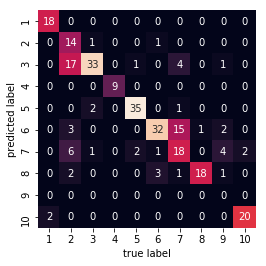

In [39]:
kproto = KPrototypes(n_clusters=kclust, init='Cao', n_init=1000, verbose=2)

clusters = kproto.fit_predict(num_scaled_with_cat, categorical=[7,8,9,10])

# Print cluster centroids of the trained model.
#print(kproto.cluster_centroids_)
# Print training statistics
#print(kproto.cost_)
#print(kproto.n_iter_)
show_output(clusters,target,'KPrototypes', kclust)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 148, ncost: 49.00851335115588
Run: 1, iteration: 2/100, moves: 51, ncost: 45.56242554691566
Run: 1, iteration: 3/100, moves: 13, ncost: 44.9950294205324
Run: 1, iteration: 4/100, moves: 5, ncost: 44.72795916288681
Run: 1, iteration: 5/100, moves: 4, ncost: 44.66788722489049
Run: 1, iteration: 6/100, moves: 0, ncost: 44.66788722489049
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 131, ncost: 48.76229687548171
Run: 2, iteration: 2/100, moves: 38, ncost: 46.56274667655156
Run: 2, iteration: 3/100, moves: 15, ncost: 46.082690724858935
Run: 2, iteration: 4/100, moves: 9, ncost: 45.87187615085781
Run: 2, iteration: 5/100, moves: 0, ncost: 45.87187615085781
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 116, ncost: 42.973846225439374
Run: 3, iteration

Starting iterations...
Run: 19, iteration: 1/100, moves: 101, ncost: 45.663590311046846
Run: 19, iteration: 2/100, moves: 35, ncost: 42.30914468583851
Run: 19, iteration: 3/100, moves: 18, ncost: 41.78365270320309
Run: 19, iteration: 4/100, moves: 4, ncost: 41.69945115461148
Run: 19, iteration: 5/100, moves: 1, ncost: 41.66056554562723
Run: 19, iteration: 6/100, moves: 1, ncost: 41.627102325559605
Run: 19, iteration: 7/100, moves: 2, ncost: 41.55535391785445
Run: 19, iteration: 8/100, moves: 1, ncost: 41.52629345184016
Run: 19, iteration: 9/100, moves: 0, ncost: 41.52629345184016
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 20, iteration: 1/100, moves: 121, ncost: 43.97882637081939
Run: 20, iteration: 2/100, moves: 38, ncost: 42.57016902440968
Run: 20, iteration: 3/100, moves: 6, ncost: 42.442683195584415
Run: 20, iteration: 4/100, moves: 2, ncost: 42.38124673114259
Run: 20, iteration: 5/100, moves: 1, ncost: 42.363953689415055
Run: 20, iteration

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 36, iteration: 1/100, moves: 106, ncost: 43.04239511298711
Run: 36, iteration: 2/100, moves: 26, ncost: 41.762235093887426
Run: 36, iteration: 3/100, moves: 6, ncost: 41.64501706370752
Run: 36, iteration: 4/100, moves: 3, ncost: 41.59500867842323
Run: 36, iteration: 5/100, moves: 4, ncost: 41.52531838724044
Run: 36, iteration: 6/100, moves: 0, ncost: 41.52531838724044
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 37, iteration: 1/100, moves: 146, ncost: 45.948124900274905
Run: 37, iteration: 2/100, moves: 36, ncost: 44.54879310197015
Run: 37, iteration: 3/100, moves: 6, ncost: 44.295478462732525
Run: 37, iteration: 4/100, moves: 2, ncost: 44.26339652592363
Run: 37, iteration: 5/100, moves: 0, ncost: 44.26339652592363
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 38, iteration: 1/100, moves: 107, ncost: 49.20446063502776
Run: 

Run: 55, iteration: 4/100, moves: 8, ncost: 44.71478334919192
Run: 55, iteration: 5/100, moves: 3, ncost: 44.6341432470702
Run: 55, iteration: 6/100, moves: 2, ncost: 44.56263586925576
Run: 55, iteration: 7/100, moves: 0, ncost: 44.56263586925576
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 56, iteration: 1/100, moves: 91, ncost: 44.33091887382563
Run: 56, iteration: 2/100, moves: 36, ncost: 42.035620583667985
Run: 56, iteration: 3/100, moves: 22, ncost: 41.263203143798684
Run: 56, iteration: 4/100, moves: 7, ncost: 41.07939872596847
Run: 56, iteration: 5/100, moves: 0, ncost: 41.07939872596847
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 57, iteration: 1/100, moves: 82, ncost: 46.51506036838658
Run: 57, iteration: 2/100, moves: 34, ncost: 44.91886691713841
Run: 57, iteration: 3/100, moves: 5, ncost: 44.86736103240785
Run: 57, iteration: 4/100, moves: 0, ncost: 44.86736103240785
Init: initializing centroids

Run: 73, iteration: 2/100, moves: 34, ncost: 42.283038926029754
Run: 73, iteration: 3/100, moves: 7, ncost: 42.17598492413435
Run: 73, iteration: 4/100, moves: 0, ncost: 42.17598492413435
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 74, iteration: 1/100, moves: 82, ncost: 45.42366177032513
Run: 74, iteration: 2/100, moves: 28, ncost: 42.37582522878125
Run: 74, iteration: 3/100, moves: 28, ncost: 40.628132148360834
Run: 74, iteration: 4/100, moves: 19, ncost: 39.84701667019709
Run: 74, iteration: 5/100, moves: 7, ncost: 39.740538510607685
Run: 74, iteration: 6/100, moves: 0, ncost: 39.740538510607685
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 75, iteration: 1/100, moves: 122, ncost: 43.56471060816425
Run: 75, iteration: 2/100, moves: 39, ncost: 41.45454217931505
Run: 75, iteration: 3/100, moves: 11, ncost: 41.26224329003254
Run: 75, iteration: 4/100, moves: 0, ncost: 41.26224329003254
Init: initializing ce

Run: 92, iteration: 3/100, moves: 12, ncost: 43.779608890761764
Run: 92, iteration: 4/100, moves: 11, ncost: 43.47185121447498
Run: 92, iteration: 5/100, moves: 0, ncost: 43.47185121447498
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 93, iteration: 1/100, moves: 97, ncost: 44.25239236561673
Run: 93, iteration: 2/100, moves: 15, ncost: 43.701213317361656
Run: 93, iteration: 3/100, moves: 12, ncost: 42.66327047306671
Run: 93, iteration: 4/100, moves: 11, ncost: 42.35922296301596
Run: 93, iteration: 5/100, moves: 3, ncost: 42.30531197080832
Run: 93, iteration: 6/100, moves: 0, ncost: 42.30531197080832
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 94, iteration: 1/100, moves: 105, ncost: 46.980570904014655
Run: 94, iteration: 2/100, moves: 44, ncost: 43.17593294678829
Run: 94, iteration: 3/100, moves: 18, ncost: 42.343045906676416
Run: 94, iteration: 4/100, moves: 9, ncost: 42.09074912255608
Run: 94, iteration: 

Run: 112, iteration: 4/100, moves: 8, ncost: 45.15013730971529
Run: 112, iteration: 5/100, moves: 9, ncost: 44.78830635205174
Run: 112, iteration: 6/100, moves: 19, ncost: 43.953342330334195
Run: 112, iteration: 7/100, moves: 3, ncost: 43.90728548907956
Run: 112, iteration: 8/100, moves: 1, ncost: 43.9029553362953
Run: 112, iteration: 9/100, moves: 0, ncost: 43.9029553362953
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 113, iteration: 1/100, moves: 114, ncost: 47.43019371109168
Run: 113, iteration: 2/100, moves: 47, ncost: 44.11412021776929
Run: 113, iteration: 3/100, moves: 14, ncost: 43.09402375136255
Run: 113, iteration: 4/100, moves: 2, ncost: 43.07768328990666
Run: 113, iteration: 5/100, moves: 0, ncost: 43.07768328990666
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 114, iteration: 1/100, m

Run: 131, iteration: 6/100, moves: 0, ncost: 45.536697458690995
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 132, iteration: 1/100, moves: 115, ncost: 45.49255112678774
Run: 132, iteration: 2/100, moves: 42, ncost: 43.1372009011061
Run: 132, iteration: 3/100, moves: 14, ncost: 42.60541283740676
Run: 132, iteration: 4/100, moves: 12, ncost: 42.301512929179445
Run: 132, iteration: 5/100, moves: 5, ncost: 42.208377360106205
Run: 132, iteration: 6/100, moves: 2, ncost: 42.184221435184
Run: 132, iteration: 7/100, moves: 6, ncost: 42.050561332158566
Run: 132, iteration: 8/100, moves: 3, ncost: 42.00805118628596
Run: 132, iteration: 9/100, moves: 2, ncost: 41.99289177672884
Run: 132, iteration: 10/100, moves: 0, ncost: 41.99289177672884
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 133, iteration: 1/100, moves: 112, ncost: 42.54285951710027
Run: 133, iteration: 2/100, moves: 28, ncost: 41.23104687051903
Run: 133, i

Run: 151, iteration: 6/100, moves: 7, ncost: 41.55573403054795
Run: 151, iteration: 7/100, moves: 5, ncost: 41.45965488107675
Run: 151, iteration: 8/100, moves: 0, ncost: 41.45965488107675
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 152, iteration: 1/100, moves: 93, ncost: 43.85371727594804
Run: 152, iteration: 2/100, moves: 35, ncost: 41.94652518610438
Run: 152, iteration: 3/100, moves: 9, ncost: 41.7167485374828
Run: 152, iteration: 4/100, moves: 2, ncost: 41.6661605090646
Run: 152, iteration: 5/100, moves: 1, ncost: 41.65246573129774
Run: 152, iteration: 6/100, moves: 0, ncost: 41.65246573129774
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 153, iteration: 1/100, moves: 110, ncost: 46.58355694748517
Run: 153, iteration: 2/100, moves: 32, ncost: 45.122235973557586
Run: 153, iteration: 3/100, moves: 12, ncost: 44.75978621634297
Run: 153, iteration: 4/100, moves: 0, ncost: 44.75978621634297
Init: initializi

Run: 169, iteration: 8/100, moves: 0, ncost: 43.24238857973222
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 170, iteration: 1/100, moves: 91, ncost: 47.70294037093176
Run: 170, iteration: 2/100, moves: 33, ncost: 45.511683242591396
Run: 170, iteration: 3/100, moves: 10, ncost: 45.28757312807333
Run: 170, iteration: 4/100, moves: 1, ncost: 45.281860809814845
Run: 170, iteration: 5/100, moves: 0, ncost: 45.281860809814845
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 171, iteration: 1/100, moves: 100, ncost: 44.307569278678095
Run: 171, iteration: 2/100, moves: 58, ncost: 40.939560846270695
Run: 171, iteration: 3/100, moves: 10, ncost: 40.43768175364045
Run: 171, iteration: 4/100, moves: 6, ncost: 40.15851880487462
Run: 171, iteration: 5/100, moves: 2, ncost: 40.1149677949192
Run: 171, iteration: 6/100, moves: 1, ncost: 40.10057934761926
Run: 171, iteration: 7/100, moves: 0, ncost: 40.10057934761926
Init: init

Run: 188, iteration: 1/100, moves: 92, ncost: 42.93499636311231
Run: 188, iteration: 2/100, moves: 17, ncost: 42.338698887974715
Run: 188, iteration: 3/100, moves: 3, ncost: 42.231068637146954
Run: 188, iteration: 4/100, moves: 4, ncost: 42.14896946104554
Run: 188, iteration: 5/100, moves: 1, ncost: 42.11466965581184
Run: 188, iteration: 6/100, moves: 0, ncost: 42.11466965581184
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 189, iteration: 1/100, moves: 72, ncost: 46.30654658149005
Run: 189, iteration: 2/100, moves: 15, ncost: 45.58505385376288
Run: 189, iteration: 3/100, moves: 8, ncost: 45.465628208074016
Run: 189, iteration: 4/100, moves: 3, ncost: 45.351931000467424
Run: 189, iteration: 5/100, moves: 1, ncost: 45.320220481992784
Run: 189, iteration: 6/100, moves: 1, ncost: 45.30893971680485
Run: 189, iteration: 7/100, moves: 0, ncost: 45.30893971680485
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 190, it

Run: 204, iteration: 1/100, moves: 115, ncost: 46.095547274216656
Run: 204, iteration: 2/100, moves: 25, ncost: 44.5090711573259
Run: 204, iteration: 3/100, moves: 7, ncost: 44.28470025050687
Run: 204, iteration: 4/100, moves: 0, ncost: 44.28470025050687
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 205, iteration: 1/100, moves: 57, ncost: 45.065526656007684
Run: 205, iteration: 2/100, moves: 21, ncost: 43.85205677391667
Run: 205, iteration: 3/100, moves: 11, ncost: 43.43256916685795
Run: 205, iteration: 4/100, moves: 4, ncost: 43.36182752262639
Run: 205, iteration: 5/100, moves: 3, ncost: 43.25380424983414
Run: 205, iteration: 6/100, moves: 1, ncost: 43.24053161618251
Run: 205, iteration: 7/100, moves: 1, ncost: 43.19212984925339
Run: 205, iteration: 8/100, moves: 0, ncost: 43.19212984925339
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 206, iteration: 1/100, moves: 120, ncost: 43.63974963856223
Run: 206, it

Run: 221, iteration: 1/100, moves: 120, ncost: 44.00051342693621
Run: 221, iteration: 2/100, moves: 56, ncost: 41.81950527543235
Run: 221, iteration: 3/100, moves: 16, ncost: 41.40843630117647
Run: 221, iteration: 4/100, moves: 8, ncost: 41.225876202385734
Run: 221, iteration: 5/100, moves: 2, ncost: 41.15260729947304
Run: 221, iteration: 6/100, moves: 4, ncost: 41.095429009128935
Run: 221, iteration: 7/100, moves: 0, ncost: 41.095429009128935
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 222, iteration: 1/100, moves: 119, ncost: 44.801850827232585
Run: 222, iteration: 2/100, moves: 25, ncost: 44.10194390281372
Run: 222, iteration: 3/100, moves: 2, ncost: 44.00050105930785
Run: 222, iteration: 4/100, moves: 0, ncost: 44.00050105930785
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 223, iteration: 1/100, moves: 105, ncost: 45.88928945597777
Run: 223, iteration: 2/100, moves: 36, ncost: 43.64626324026588
Run: 22

Init: initializing clusters
Starting iterations...
Run: 239, iteration: 1/100, moves: 111, ncost: 42.918450689082334
Run: 239, iteration: 2/100, moves: 36, ncost: 40.56605299380726
Run: 239, iteration: 3/100, moves: 3, ncost: 40.54145994933312
Run: 239, iteration: 4/100, moves: 2, ncost: 40.48841321605564
Run: 239, iteration: 5/100, moves: 0, ncost: 40.48841321605564
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 240, iteration: 1/100, moves: 98, ncost: 48.69004903903726
Run: 240, iteration: 2/100, moves: 30, ncost: 46.86932654987734
Run: 240, iteration: 3/100, moves: 18, ncost: 45.2920076725259
Run: 240, iteration: 4/100, moves: 11, ncost: 45.078345328679916
Run: 240, iteration: 5/100, moves: 1, ncost: 45.06386363673573
Run: 240, iteration: 6/100, moves: 0, ncost: 45.06386363673573
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 241, iteration: 1/100, moves: 87, ncost: 45.703512936036965
Run: 241, iteration: 2/

Run: 256, iteration: 5/100, moves: 0, ncost: 42.18791054976605
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 257, iteration: 1/100, moves: 99, ncost: 44.21176406609517
Run: 257, iteration: 2/100, moves: 25, ncost: 43.44126538632532
Run: 257, iteration: 3/100, moves: 4, ncost: 43.3822332312914
Run: 257, iteration: 4/100, moves: 2, ncost: 43.36118362855042
Run: 257, iteration: 5/100, moves: 1, ncost: 43.35407631061561
Run: 257, iteration: 6/100, moves: 0, ncost: 43.35407631061561
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 258, iteration: 1/100, moves: 91, ncost: 46.342667688546115
Run: 258, iteration: 2/100, moves: 38, ncost: 44.498981329688625
Run: 258, iteration: 3/100, moves: 11, ncost: 44.23946401520298
Run: 258, iteration: 4/100, moves: 3, ncost: 44.20961426985815
Run: 258, iteration: 5/100, moves: 0, ncost: 44.20961426985815
Init: initializing centroids
Init: initializing clusters
Starting iterations..

Run: 273, iteration: 3/100, moves: 16, ncost: 45.16956608188748
Run: 273, iteration: 4/100, moves: 3, ncost: 45.109117813916896
Run: 273, iteration: 5/100, moves: 0, ncost: 45.109117813916896
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 274, iteration: 1/100, moves: 121, ncost: 44.74768330245819
Run: 274, iteration: 2/100, moves: 40, ncost: 43.36873731845681
Run: 274, iteration: 3/100, moves: 13, ncost: 43.021389235522555
Run: 274, iteration: 4/100, moves: 11, ncost: 42.331234707520814
Run: 274, iteration: 5/100, moves: 4, ncost: 42.249385441836274
Run: 274, iteration: 6/100, moves: 1, ncost: 42.23529149410142
Run: 274, iteration: 7/100, moves: 1, ncost: 42.228267918210605
Run: 274, iteration: 8/100, moves: 0, ncost: 42.228267918210605
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 275, iteration: 1/100, moves: 105, ncost: 43.82817682686733
Run: 275, iteration: 2/100, moves: 27, ncost: 43.09582024082872
Run: 

Run: 291, iteration: 3/100, moves: 6, ncost: 39.849830626184065
Run: 291, iteration: 4/100, moves: 2, ncost: 39.75259820063918
Run: 291, iteration: 5/100, moves: 0, ncost: 39.75259820063918
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 292, iteration: 1/100, moves: 98, ncost: 45.10047937606516
Run: 292, iteration: 2/100, moves: 24, ncost: 44.2467968783519
Run: 292, iteration: 3/100, moves: 2, ncost: 44.21042787246649
Run: 292, iteration: 4/100, moves: 0, ncost: 44.21042787246649
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 293, iteration: 1/100, moves: 101, ncost: 50.87634714821264
Run: 293, iteration: 2/100, moves: 46, ncost: 49.27128897307691
Run: 293, iteration: 3/100, moves: 13, ncost: 48.902222773756684
Run: 293, iteration: 4/100, moves: 9, ncost: 48.70371709603707
Run: 293, iteration: 5/100, moves: 3, ncost: 47.97112801061799
Run: 293, iteration: 6/100, moves: 5, ncost: 47.92377863953961
Run: 293, iter

Run: 310, iteration: 1/100, moves: 129, ncost: 46.183250891993005
Run: 310, iteration: 2/100, moves: 35, ncost: 44.75970999265132
Run: 310, iteration: 3/100, moves: 8, ncost: 44.2082778095142
Run: 310, iteration: 4/100, moves: 2, ncost: 44.16154828490319
Run: 310, iteration: 5/100, moves: 2, ncost: 44.130056978137254
Run: 310, iteration: 6/100, moves: 0, ncost: 44.130056978137254
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 311, iteration: 1/100, moves: 127, ncost: 48.159313673186674
Run: 311, iteration: 2/100, moves: 34, ncost: 46.5225748446482
Run: 311, iteration: 3/100, moves: 15, ncost: 45.364768841281844
Run: 311, iteration: 4/100, moves: 11, ncost: 44.88269282619718
Run: 311, iteration: 5/100, moves: 2, ncost: 44.79736141974048
Run: 311, iteration: 6/100, moves: 13, ncost: 43.96401119888454
Run: 311, iteration: 7/100, moves: 7, ncost: 43.68385387920928
Run: 311, iteration: 8/100, move

Run: 327, iteration: 1/100, moves: 93, ncost: 45.014608123909575
Run: 327, iteration: 2/100, moves: 21, ncost: 44.011058045449744
Run: 327, iteration: 3/100, moves: 4, ncost: 43.955249769016156
Run: 327, iteration: 4/100, moves: 0, ncost: 43.955249769016156
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 328, iteration: 1/100, moves: 154, ncost: 45.449467778201786
Run: 328, iteration: 2/100, moves: 30, ncost: 44.05276359159395
Run: 328, iteration: 3/100, moves: 7, ncost: 43.94715790447496
Run: 328, iteration: 4/100, moves: 0, ncost: 43.94715790447496
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 329, iteration: 1/100, moves: 117, ncost: 41.38369723914244
Run: 329, iteration: 2/100, moves: 13, ncost: 41.02929173438407
Run: 329, iteration: 3/100, moves: 2, ncost: 40.97105916724402
Run: 329, iteration:

Run: 345, iteration: 1/100, moves: 124, ncost: 43.72440878929133
Run: 345, iteration: 2/100, moves: 33, ncost: 42.56638310585282
Run: 345, iteration: 3/100, moves: 4, ncost: 42.49932179632647
Run: 345, iteration: 4/100, moves: 1, ncost: 42.49616861957321
Run: 345, iteration: 5/100, moves: 0, ncost: 42.49616861957321
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 346, iteration: 1/100, moves: 98, ncost: 48.790857804537616
Run: 346, iteration: 2/100, moves: 35, ncost: 46.925023572254126
Run: 346, iteration: 3/100, moves: 18, ncost: 46.186469400045624
Run: 346, iteration: 4/100, moves: 5, ncost: 46.07143589314319
Run: 346, iteration: 5/100, moves: 0, ncost: 46.07143589314319
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 347, iteration: 1/100, moves: 115, ncost: 44.82417417227482
Run: 347, iteration: 2/100, moves: 41, ncost: 42.949757130421354
Run: 347, iteration: 3/100, moves: 14, ncost: 42.24310914346014
Run: 34

Run: 363, iteration: 2/100, moves: 26, ncost: 44.112983199152296
Run: 363, iteration: 3/100, moves: 8, ncost: 43.916421682087524
Run: 363, iteration: 4/100, moves: 5, ncost: 43.44898434302757
Run: 363, iteration: 5/100, moves: 5, ncost: 43.38379031717558
Run: 363, iteration: 6/100, moves: 3, ncost: 43.28628289346096
Run: 363, iteration: 7/100, moves: 0, ncost: 43.28628289346096
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 364, iteration: 1/100, moves: 134, ncost: 46.84450682535141
Run: 364, iteration: 2/100, moves: 61, ncost: 41.80727420600956
Run: 364, iteration: 3/100, moves: 24, ncost: 40.97162757159646
Run: 364, iteration: 4/100, moves: 6, ncost: 40.82730726890349
Run: 364, iteration: 5/100, moves: 0, ncost: 40.82730726890349
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 365, iteration: 1/100, moves: 101, ncost: 46.218333120278274
Run: 365, iterati

Run: 381, iteration: 6/100, moves: 0, ncost: 42.95905509798311
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 382, iteration: 1/100, moves: 128, ncost: 43.16020229211974
Run: 382, iteration: 2/100, moves: 22, ncost: 42.454670211980776
Run: 382, iteration: 3/100, moves: 13, ncost: 41.31591959933735
Run: 382, iteration: 4/100, moves: 4, ncost: 41.206088121638636
Run: 382, iteration: 5/100, moves: 0, ncost: 41.206088121638636
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 383, iteration: 1/100, moves: 107, ncost: 44.65278229387787
Run: 383, iteration: 2/100, moves: 25, ncost: 43.46711294664816
Run: 383, iteration: 3/100, moves: 4, ncost: 43.348504753891376
Run: 383, iteration: 4/100, moves: 2, ncost: 43.29559594625376
Run: 383, iteration: 5/100, moves: 0, ncost: 43.29559594625376
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 384, iteration: 1/100, moves: 83, ncost: 44.6376200

Run: 400, iteration: 3/100, moves: 19, ncost: 41.500080708012945
Run: 400, iteration: 4/100, moves: 8, ncost: 41.403589735045166
Run: 400, iteration: 5/100, moves: 0, ncost: 41.403589735045166
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 401, iteration: 1/100, moves: 111, ncost: 49.21225301058822
Run: 401, iteration: 2/100, moves: 48, ncost: 44.626715483286844
Run: 401, iteration: 3/100, moves: 13, ncost: 44.06252188240565
Run: 401, iteration: 4/100, moves: 4, ncost: 43.98930411382053
Run: 401, iteration: 5/100, moves: 0, ncost: 43.98930411382053
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 402, iteration: 1/100, moves: 89, ncost: 43.89541109846704
Run: 402, iteration: 2/100, moves: 26, ncost: 42.94834044978893
Run: 402, iteration: 3/100, moves: 5, ncost: 42.87921374575147
Run: 402, iteration: 4/100, moves: 0, ncost: 42.87921374575147
Init: initializing centroids
Init: initializing clusters
Starting iterati

Run: 419, iteration: 3/100, moves: 37, ncost: 44.64163415330329
Run: 419, iteration: 4/100, moves: 15, ncost: 44.06679788669845
Run: 419, iteration: 5/100, moves: 11, ncost: 43.075839219896444
Run: 419, iteration: 6/100, moves: 6, ncost: 42.972229163850486
Run: 419, iteration: 7/100, moves: 3, ncost: 42.932133694322324
Run: 419, iteration: 8/100, moves: 0, ncost: 42.932133694322324
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 420, iteration: 1/100, moves: 102, ncost: 46.23414624362438
Run: 420, iteration: 2/100, moves: 19, ncost: 44.892276046334885
Run: 420, iteration: 3/100, moves: 1, ncost: 44.76728431364144
Run: 420, iteration: 4/100, moves: 1, ncost: 44.712714829762454
Run: 420, iteration: 5/100, moves: 0, ncost: 44.712714829762454
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 421, iteration: 1/100, moves: 117, ncost: 43.05022800082117
Run: 421, it

Run: 437, iteration: 1/100, moves: 99, ncost: 48.092165108759865
Run: 437, iteration: 2/100, moves: 21, ncost: 46.80892272027994
Run: 437, iteration: 3/100, moves: 9, ncost: 46.48796317286179
Run: 437, iteration: 4/100, moves: 5, ncost: 46.39440189517141
Run: 437, iteration: 5/100, moves: 2, ncost: 46.37753834135771
Run: 437, iteration: 6/100, moves: 0, ncost: 46.37753834135771
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 438, iteration: 1/100, moves: 134, ncost: 42.80502443913602
Run: 438, iteration: 2/100, moves: 19, ncost: 42.43583814123686
Run: 438, iteration: 3/100, moves: 2, ncost: 42.39181803770535
Run: 438, iteration: 4/100, moves: 14, ncost: 41.498308717040786
Run: 438, iteration: 5/100, moves: 4, ncost: 41.42445864155159
Run: 438, iteration: 6/100, moves: 0, ncost: 41.42445864155159
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 439, iteration: 1/100, moves: 127, ncost: 48.224422651944884
Run: 439, 

Run: 455, iteration: 7/100, moves: 1, ncost: 44.13964993050309
Run: 455, iteration: 8/100, moves: 0, ncost: 44.13964993050309
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 456, iteration: 1/100, moves: 143, ncost: 48.16209415839783
Run: 456, iteration: 2/100, moves: 45, ncost: 42.44558891717043
Run: 456, iteration: 3/100, moves: 21, ncost: 40.50998881588874
Run: 456, iteration: 4/100, moves: 4, ncost: 40.444581421077366
Run: 456, iteration: 5/100, moves: 2, ncost: 40.4190223871823
Run: 456, iteration: 6/100, moves: 0, ncost: 40.4190223871823
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 457, iteration: 1/100, moves: 85, ncost: 45.008182505145164
Run: 457, iteration: 2/100, moves: 33, ncost: 43.44424750631216
Run: 457, iteration: 3/100, moves: 5, ncost: 43.36389750710244
Run: 457, iteration: 4/100, moves: 1, ncost: 43.357877051018825
Run: 457, iteration: 5/100, moves: 0, ncost: 43.357877051018825
Init: initial

Run: 473, iteration: 5/100, moves: 4, ncost: 41.76818040054247
Run: 473, iteration: 6/100, moves: 1, ncost: 41.75853567452113
Run: 473, iteration: 7/100, moves: 0, ncost: 41.75853567452113
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 474, iteration: 1/100, moves: 136, ncost: 42.002936397976676
Run: 474, iteration: 2/100, moves: 29, ncost: 40.8425057083997
Run: 474, iteration: 3/100, moves: 24, ncost: 39.932560458787954
Run: 474, iteration: 4/100, moves: 3, ncost: 39.90957204512092
Run: 474, iteration: 5/100, moves: 1, ncost: 39.89367099940234
Run: 474, iteration: 6/100, moves: 0, ncost: 39.89367099940234
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 475, iteration: 1/100, moves: 95, ncost: 47.27459050090491
Run: 475, iteration: 2/100, moves: 47, ncost: 42.20653164942885
Run: 475, iteration: 3/100, moves: 24, ncost: 41.314608502409584
Run: 475, iteratio

Run: 489, iteration: 10/100, moves: 0, ncost: 42.82970398769431
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 490, iteration: 1/100, moves: 119, ncost: 48.34895668331856
Run: 490, iteration: 2/100, moves: 50, ncost: 45.161218442998184
Run: 490, iteration: 3/100, moves: 21, ncost: 43.942129486678674
Run: 490, iteration: 4/100, moves: 11, ncost: 43.63504019636515
Run: 490, iteration: 5/100, moves: 1, ncost: 43.623676837906814
Run: 490, iteration: 6/100, moves: 0, ncost: 43.623676837906814
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 491, iteration: 1/100, moves: 131, ncost: 41.67712532336927
Run: 491, iteration: 2/100, moves: 33, ncost: 40.27669027541261
Run: 491, iteration: 3/100, moves: 3, ncost: 40.251829353852756
Run: 491, iteration: 4/100, moves: 0, ncost: 40.251829353852756
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 492, iteration: 1/100, moves: 98, ncost: 46.206

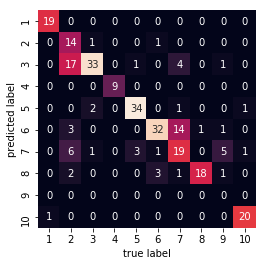

In [40]:
kproto = KPrototypes(n_clusters=kclust, init='Huang', n_init=500, verbose=2)

clusters = kproto.fit_predict(num_scaled_with_cat, categorical=[7,8,9,10])

show_output(clusters,target,'KPrototypes', kclust)
